<a href="https://colab.research.google.com/github/Tommibotti/Climate-change-shift-project/blob/main/Emilia_Romagna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#To do list

1. finire la correlazione della domanda 2
2. modello lineare su depopolamento (e migrazione)
3. vedere come rispondere alla domanda 4
4. Iniziare a scrivere il report
5. Rivedere tutto lo script

#Intro


##Domande di ricerca

1.  Quali sono le caratteristiche distintive delle aree interessate dal fenomeno del depopolamento?

2. Qual è la relazione tra l'età media della popolazione con lo stato degli edifici (data di costruzione e stato di conservazione), e la fragilità naturale (precipitazioni, frane, rischi idraulici)?

3. Quali sono le caratteristiche più influenti per le Morti (0-64) (65+)?

4. Identificare comuni a rischio: Mappare i comuni più vulnerabili per supportare politiche di intervento.
Creare un indicatore per identificare il grado di rischio naturale comunale (grado da 1 a 5)
e analizzare le caratteristiche più frequenti per grado uguale

## Variabli Calcolate

- Edifici_new (diverse var): Edifici / Totale Edifici comune

- Aree_new(diverse var): Aree pericolose / superficie totale comune

- Decessi_perc (0-64)(65+): Decessi (0-64)/ Popolazione(0-64)
  - Decessi (65+): somma vari range Decessi da 65 in poi
  - Decessi (0-64): Decessi tot - Decessi (65+)
  - Popolazione (0-64): Pop_tot*(Perc_giovanile + Perc_lavorativa)
  - Popolazione (0-64): Pop_tot*(Perc_anziana)


- Ignoranti: Popolazione con titolo di studio... / pop tot

#Accesso al Drive

In [ ]:
from google.colab import drive

# Collega Google Drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Data4Resilience_mio'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset_completo.csv  df_pulito.csv


# Parte 1 : Pulizia Dataset

## Caricamento Dataset iniziale

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
file_path = '/content/drive/My Drive/Data4Resilience_mio/dataset_completo.csv'

df = pd.read_csv(file_path)

print(df.head())

   Anno  Mese Nome_Unità_Territoriale  Codice_Unità_Territoriale  Valore  \
0  2004   1.0                AGAZZANO                      33001     1.0   
1  2004   2.0                AGAZZANO                      33001     2.0   
2  2004   3.0                AGAZZANO                      33001     3.0   
3  2004   4.0                AGAZZANO                      33001     1.0   
4  2004   5.0                AGAZZANO                      33001     1.0   

       Indicatore  Unità_Territoriale  Codice_Indicatore  \
0  Decessi maschi                   1              10001   
1  Decessi maschi                   1              10001   
2  Decessi maschi                   1              10001   
3  Decessi maschi                   1              10001   
4  Decessi maschi                   1              10001   

   Periodicità_Indicatore Provincia  
0                       1  PIACENZA  
1                       1  PIACENZA  
2                       1  PIACENZA  
3                       1  PIA

In [ ]:
#Informazioni sul dataset:
#df.info()
#df['Indicatore'].unique()

## Imputazione Mesi NA

In [ ]:
#Valori nulli per colonna:
df.isnull().sum()
df.fillna(0, inplace=True)
#df.isnull().sum()

## Rimozione Mese 13

In [ ]:
# Rimuovo dal dataset df tutte le righe che hanno Mese=13
df = df[df['Mese'] != 13]

## Calcolo età media in popolazione

In [ ]:
# Filtro il DataFrame per righe che contengono "Popolazione residente totale" con un'età
df_pop = df[df['Indicatore'].str.contains(
    r'Popolazione residente totale di \d+ anni di età|Popolazione residente totale di 100 e oltre anni di età',
    na=False
)].copy()  # <-- Importante per evitare SettingWithCopyWarning

# Estraggo l'età dalla stringa "Indicatore"
df_pop.loc[:, 'Età'] = df_pop['Indicatore'].str.extract(r'(\d+)', expand=False).astype(float)

# Età * Valore
df_pop.loc[:, 'Prodotto Età'] = df_pop['Età'] * df_pop['Valore']

# Età media per ogni combinazione di Anno e Città
media_ponderata = df_pop.groupby(['Anno', 'Nome_Unità_Territoriale']).apply(
    lambda group: (group['Prodotto Età'].sum() / group['Valore'].sum())
).reset_index(name='Età media')

# Arrotondamento
media_ponderata['Età media'] = media_ponderata['Età media'].round(2)

# Merge con il dataframe originale
df_pop = df_pop.merge(media_ponderata, on=['Anno', 'Nome_Unità_Territoriale'], how='left')

# Aggiorno i valori della colonna 'Indicatore' e 'Valore'
df_pop.loc[:, 'Indicatore'] = 'Età media'
df_pop.loc[:, 'Valore'] = df_pop['Età media']

# Rimuovo colonne non necessarie
df_pop = df_pop.drop(columns=['Età', 'Prodotto Età', 'Età media'])

# Mantengo solo una riga per ogni combinazione di 'Anno' e 'Nome_Unità_Territoriale'
df_pop = df_pop.drop_duplicates(subset=['Anno', 'Nome_Unità_Territoriale'])

# Aggiungo le nuove righe al DataFrame originale
df = pd.concat([df, df_pop], ignore_index=True)

# Seleziono solo le righe con l'indicatore 'Età media'
nuove_righe_età = df[df['Indicatore'] == 'Età media']

<ipython-input-169-c25cd4b564f2>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_ponderata = df_pop.groupby(['Anno', 'Nome_Unità_Territoriale']).apply(


##Selezione variabili di interesse

Ridenominazione delle variablili con parentesi

In [ ]:
# Le parentesi causavano problemi
valori_da_sostituire = [
    "Aree a Pericolosità idraulica bassa P1 (scarsa probabilità di alluvioni o scenari di eventi estremi)",
    "Aree a Pericolosità idraulica media P2 (tempo di ritorno tra 100 e 200 anni)",
    "Aree a Pericolosità idraulica elevata P3 (tempo di ritorno tra 20 e 50 anni) ",
    "Quota di edifici residenziali costruiti prima del 1919 (%)",
    "Quota di edifici residenziali costruiti tra il 1919-1945 (%)",
    "Quota di edifici residenziali costruiti tra il 1946-1960 (%)",
    "Quota di edifici residenziali costruiti tra il 1961-1970 (%)",
    "Quota di edifici residenziali costruiti tra il 1971-1980 (%)",
    "Quota di edifici residenziali costruiti tra il 1981-1990 (%)",
    "Quota di edifici residenziali costruiti tra il 1991-2000 (%)",
    "Quota di edifici residenziali costruiti tra il 2001-2005 (%)",
    "Quota di edifici residenziali costruiti dopo il 2005  (%)",
    "Indice composito di fragilità comunale - (decile)",
    "Altitudine del centro (metri)",
    "Superficie territoriale (kmq) al 01/01/2023",
    "Tasso di occupazione (20-64 anni)",
    "Densità delle unità locali dell’industria e dei servizi - (ventile)"
]

# Sostituire le parentesi con '_'
def rimuovi_parentesi(valore):
    return valore.replace("(", "_").replace(")", "_")

# Rinominazione dei valori nella colonna 'Indicatore'
mappatura_valori = {valore: rimuovi_parentesi(valore) for valore in valori_da_sostituire}
df["Indicatore"] = df["Indicatore"].replace(mappatura_valori)

Selezione variabili

In [ ]:
variabili = r"^(Età media|Nati totali|Edifici ad uso residenziale|Raccolta indifferenziata dei rifiuti urbani per abitante|Aree protette|Tasso di occupazione _20-64 anni_|Densità delle unità locali dell’industria e dei servizi - _ventile_|Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale|Abitazioni totali|Indice di esposizione demografica|Indice di vulnerabilità sociale e materiale|Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_|Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_|Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_|Quota di edifici residenziali costruiti prima del 1919 _%_|Quota di edifici residenziali costruiti tra il 1919-1945 _%_|Quota di edifici residenziali costruiti tra il 1946-1960 _%_|Quota di edifici residenziali costruiti tra il 1961-1970 _%_|Quota di edifici residenziali costruiti tra il 1971-1980 _%_|Quota di edifici residenziali costruiti tra il 1981-1990 _%_|Quota di edifici residenziali costruiti tra il 1991-2000 _%_|Quota di edifici residenziali costruiti tra il 2001-2005 _%_|Quota di edifici residenziali costruiti dopo il 2005  _%_|Edifici ad uso residenziale con stato di conservazione ottimo|Edifici ad uso residenziale con stato di conservazione buono|Edifici ad uso residenziale con stato di conservazione mediocre|Edifici ad uso residenziale con stato di conservazione pessimo|Indice composito di fragilità comunale - _decile_|Precipitazioni medie mensili|Area a Pericolosità da frana PAI molto elevata|Area a Pericolosità da frana PAI elevata|Area a Pericolosità da frana PAI media|Area a Pericolosità da frana PAI moderata|Altitudine del centro _metri_|Temperatura media mensile|Temperatura massima media mensile|Temperatura minima media mensile|Tasso di motorizzazione ad alta emissione|Indice di accessibilità ai servizi essenziali|Grado di urbanizzazione|Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale|Popolazione residente totale di tutte le età|Superficie territoriale _kmq_ al 01/01/2023|Consumo del suolo|Percentuale grandi anziani|Percentuale pop in età lavorativa|Percentuale pop giovanile|Percentuale pop anziana|Decessi totali|Decessi maschi tra i 65 e i 74 anni|Decessi femmine tra i 65 e i 74 anni|Decessi maschi tra i 75 e gli 84 anni|Decessi femmine tra i 75 e gli 84 anni|Decessi maschi con 85 e più anni|Decessi femmine con 85 e più anni)"

# Filtra le righe selezionate
df_filtrato = df[df['Indicatore'].str.contains(variabili, na=False)]
#df_filtrato.info()

<ipython-input-171-459db4c413cd>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrato = df[df['Indicatore'].str.contains(variabili, na=False)]


In [ ]:
#df_filtrato['Indicatore'].nunique()
#df_filtrato['Indicatore'].unique()

## Unione delle unità territoriali aggregatesi nel tempo

Sostituzione codici e nomi delle unità territoriali

In [ ]:
# Gruppo di comuni con codici univoci multipli
result = (
    df_filtrato.groupby("Nome_Unità_Territoriale")
    .agg(number_of_codes=("Codice_Unità_Territoriale", "nunique"))
    .reset_index()
    .query("number_of_codes > 1")
)

# Dizionari per sostituzioni
codice_unita_mapping = {
    "MONTECOPIOLO": 99030,
    "SASSOFELTRIO": 99031,
    "BAZZANO": 37061,
    "CRESPELLANO": 37061,
    "CASTELLO DI SERRAVALLE": 37061,
    "SAVIGNO": 37061,
    "MONTEVEGLIO": 37061,
    "POGGIO BERNI": 99028,
    "TORRIANA": 99028,
    "SISSA": 34049,
    "TRECASALI": 34049,
    "MASSA FISCAGLIA": 38027,
    "MIGLIARO": 38027,
    "MIGLIARINO": 38027,
    "BUSANA": 35046,
    "COLLAGNA": 35046,
    "LIGONCHIO": 35046,
    "RAMISETO": 35046,
    "GRANAGLIONE": 37062,
    "PORRETTA TERME": 37062,
    "POLESINE PARMENSE": 34050,
    "ZIBELLO": 34050,
    "MONTESCUDO": 99029,
    "MONTE COLOMBO": 99029,
    "MIRABELLO": 38028,
    "SANT'AGOSTINO": 38028,
    "CAMINATA": 33049,
    "NIBBIANO": 33049,
    "PECORARA": 33049,
    "MEZZANI": 34051,
    "SORBOLO": 34051,
    "BERRA": 38029,
    "RO": 38029,
    "TRESIGALLO": 38030,
    "FORMIGNANA": 38030
}

# Sostituzione dei codici unità territoriali
df_filtrato.loc[:, "Codice_Unità_Territoriale"] = df_filtrato["Nome_Unità_Territoriale"].map(codice_unita_mapping).fillna(
    df_filtrato["Codice_Unità_Territoriale"]
)

provincia_mapping = {
    "MONTECOPIOLO": "RIMINI",
    "SASSOFELTRIO": "RIMINI",
}

# Sostituzione delle province
df_filtrato.loc[:, "Provincia"] = df_filtrato["Nome_Unità_Territoriale"].map(provincia_mapping).fillna(df_filtrato["Provincia"])

# Modifica dei nomi unità territoriali
nome_unita_mapping = {
     "BAZZANO": "VALSAMOGGIA",
    "CRESPELLANO": "VALSAMOGGIA",
    "CASTELLO DI SERRAVALLE": "VALSAMOGGIA",
    "SAVIGNO": "VALSAMOGGIA",
    "MONTEVEGLIO": "VALSAMOGGIA",
    "POGGIO BERNI": "POGGIO TORRIANA",
    "TORRIANA": "POGGIO TORRIANA",
    "SISSA": "SISSA TRECASALI",
    "TRECASALI": "SISSA TRECASALI",
    "MASSA FISCAGLIA": "FISCAGLIA",
    "MIGLIARO": "FISCAGLIA",
    "MIGLIARINO": "FISCAGLIA",
    "BUSANA": "VENTASSO",
    "COLLAGNA": "VENTASSO",
    "LIGONCHIO": "VENTASSO",
    "RAMISETO": "VENTASSO",
    "GRANAGLIONE": "ALTO RENO TERME",
    "PORRETTA TERME": "ALTO RENO TERME",
    "POLESINE PARMENSE": "POLESINE ZIBELLO",
    "ZIBELLO": "POLESINE ZIBELLO",
    "MONTESCUDO": "MONTESCUDO-MONTE COLOMBO",
    "MONTE COLOMBO": "MONTESCUDO-MONTE COLOMBO",
    "MIRABELLO": "TERRE DEL RENO",
    "SANT'AGOSTINO": "TERRE DEL RENO",
    "CAMINATA": "ALTA VAL TIDONE",
    "NIBBIANO": "ALTA VAL TIDONE",
    "PECORARA": "ALTA VAL TIDONE",
    "MEZZANI": "SORBOLO MEZZANI",
    "SORBOLO": "SORBOLO MEZZANI",
    "BERRA": "RIVA DEL PO",
    "RO": "RIVA DEL PO",
    "TRESIGALLO": "TRESIGNANA",
    "FORMIGNANA": "TRESIGNANA",
    "CIANO D'ENZA": "CANOSSA"
}

# Sostituzione dei nomi delle unità territoriali
df_filtrato.loc[:, "Nome_Unità_Territoriale"] = df_filtrato["Nome_Unità_Territoriale"].replace(nome_unita_mapping)

df_filtrato['Nome_Unità_Territoriale'].nunique()  # Ora dovrebbero essere 330

330

Agglomerazione delle unità territoriali univoche

In [ ]:
# Variabili da sommare
sum_ind = [
    "Decessi totali","Decessi maschi tra i 65 e i 74 anni", "Decessi femmine tra i 65 e i 74 anni",
    "Decessi maschi tra i 75 e gli 84 anni", "Decessi femmine tra i 75 e gli 84 anni",
    "Decessi maschi con 85 e più anni","Decessi femmine con 85 e più anni",
    "Superficie territoriale _kmq_ al 01/01/2023",
    "Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale",
    "Area a Pericolosità da frana PAI molto elevata",
    "Area a Pericolosità da frana PAI elevata",
    "Area a Pericolosità da frana PAI media",
    "Area a Pericolosità da frana PAI moderata",
    "Area a Pericolosità da frana PAI molto elevata e elevata",
    "Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_",
    "Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_",
    "Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ ",
    "Edifici ad uso residenziale con stato di conservazione ottimo",
    "Edifici ad uso residenziale con stato di conservazione buono",
    "Edifici ad uso residenziale con stato di conservazione mediocre",
    "Edifici ad uso residenziale con stato di conservazione pessimo",
    "Popolazione residente totale di tutte le età",
    "Edifici ad uso residenziale",
    "Aree protette",
    "Abitazioni totali", "Nati totali"
]

# Variabili per cui calcolare la media
mean_ind = [
    "Età media",
    "Temperatura media mensile", "Temperatura massima media mensile","Temperatura minima media mensile",
    "Precipitazioni medie mensili",
    "Altitudine del centro _metri_",
    "Grado di urbanizzazione",
    "Percentuale grandi anziani","Percentuale pop in età lavorativa", "Percentuale pop giovanile","Percentuale pop anziana",
    "Indice composito di fragilità comunale - _decile_",
    "Tasso di motorizzazione ad alta emissione",
    "Consumo del suolo",
    "Indice di accessibilità ai servizi essenziali",
    "Quota di edifici residenziali costruiti prima del 1919 _%_","Quota di edifici residenziali costruiti tra il 1919-1945 _%_",
    "Quota di edifici residenziali costruiti tra il 1946-1960 _%_","Quota di edifici residenziali costruiti tra il 1961-1970 _%_",
    "Quota di edifici residenziali costruiti tra il 1971-1980 _%_","Quota di edifici residenziali costruiti tra il 1981-1990 _%_",
    "Quota di edifici residenziali costruiti tra il 1991-2000 _%_","Quota di edifici residenziali costruiti tra il 2001-2005 _%_",
    "Quota di edifici residenziali costruiti dopo il 2005  _%_",
    'Raccolta indifferenziata dei rifiuti urbani per abitante',
    'Tasso di occupazione _20-64 anni_',
    'Densità delle unità locali dell’industria e dei servizi - _ventile_',
    'Indice di esposizione demografica',
    'Indice di vulnerabilità sociale e materiale',
    "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale"
]

# Lista per memorizzare i DataFrame aggregati
dati_aggregati_list = []

# Per ogni indicatore unico nei dati filtra il sottogruppo per l'indicatore corrente
for ind in df_filtrato['Indicatore'].unique():
    subgroup = df_filtrato[df_filtrato['Indicatore'] == ind]

    # Colonne per il groupby
    group_cols = [
        'Anno', 'Mese', 'Nome_Unità_Territoriale',
        'Codice_Unità_Territoriale', 'Indicatore',
        'Unità_Territoriale', 'Codice_Indicatore',
        'Periodicità_Indicatore', 'Provincia'
    ]

    if ind in sum_ind:
        risultato = subgroup.groupby(group_cols)['Valore'].sum().reset_index()
    elif ind in mean_ind:
        risultato = subgroup.groupby(group_cols)['Valore'].mean().reset_index()

    dati_aggregati_list.append(risultato)

# Concatena tutti i risultati
df_aggregato = pd.concat(dati_aggregati_list, ignore_index=True)


Controllo

In [ ]:
#1
# Verifica assenza di duplicati
verifica_duplicati = (df_aggregato.groupby(['Anno', 'Mese', 'Nome_Unità_Territoriale', 'Indicatore'])
                     .size()
                     .reset_index(name='n_occorrenze')
                     .query('n_occorrenze > 1'))
print(verifica_duplicati)

#2
#calcolo e confronto somme e media
dati_originali_somma = df_filtrato[
    (df_filtrato['Indicatore'] == sum_ind[0]) &
    (df_filtrato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]
df_aggregato_somma = df_aggregato[
    (df_aggregato['Indicatore'] == sum_ind[0]) &
    (df_aggregato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]

dati_originali_media = df_filtrato[
    (df_filtrato['Indicatore'] == mean_ind[0]) &
    (df_filtrato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]
df_aggregato_media = df_aggregato[
    (df_aggregato['Indicatore'] == mean_ind[0]) &
    (df_aggregato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]

print("Somma dei valori originali (somma):", dati_originali_somma['Valore'].sum())
print("Valore nei dati aggregati (somma):", df_aggregato_somma['Valore'].sum())

print("Media dei valori originali (media):", dati_originali_media['Valore'].mean())
print("Valore nei dati aggregati (media):", df_aggregato_media['Valore'].mean())


        Anno  Mese Nome_Unità_Territoriale               Indicatore  \
2       2000   0.0                AGAZZANO  Percentuale pop anziana   
8       2000   0.0                ALBARETO  Percentuale pop anziana   
14      2000   0.0                 ALBINEA  Percentuale pop anziana   
20      2000   0.0               ALFONSINE  Percentuale pop anziana   
26      2000   0.0                  ALSENO  Percentuale pop anziana   
...      ...   ...                     ...                      ...   
797867  2023   0.0                VOGHIERA  Percentuale pop anziana   
797876  2023   0.0                   ZERBA  Percentuale pop anziana   
797885  2023   0.0        ZIANO PIACENTINO  Percentuale pop anziana   
797894  2023   0.0                   ZOCCA  Percentuale pop anziana   
797903  2023   0.0            ZOLA PREDOSA  Percentuale pop anziana   

        n_occorrenze  
2                  5  
8                  5  
14                 5  
20                 5  
26                 5  
...      

## Cancellazione unità territoriali che hanno cambiato regione

In [ ]:
# Lista dei comuni che facevano o fanno parte della regione Marche
comuni_marche = [
    "CASTELDELCI",
    "MAIOLO",
    "NOVAFELTRIA",
    "PENNABILLI",
    "SAN LEO",
    "SANT'AGATA FELTRIA",
    "TALAMELLO",
    "MONTECOPIOLO",
    "SASSOFELTRIO"
]

# Filtra i dati eliminando i comuni che appartenevano alle Marche
df_ridotto = df_aggregato[~df_aggregato['Nome_Unità_Territoriale'].str.upper().isin(comuni_marche)]

# Verifica il numero univoco di territori rimasti
df_ridotto['Nome_Unità_Territoriale'].nunique()  # Ora dovrebbero essere 321


321

## Creazione Wide form Dataset

In [ ]:
# Rimuovo alcune colonne inutili relative all'Indicatore
df_ridottocol = df_ridotto.drop(columns=['Codice_Indicatore','Unità_Territoriale'])

In [ ]:
# Separo i dati annuali (Mese = 0) e quelli mensili
df_annuale = df_ridottocol[df_ridottocol['Mese'] == 0].copy()
df_mensile = df_ridottocol[df_ridottocol['Mese'] != 0]

# Duplico i dati annuali per tutti i 12 mesi
df_annuale_long = pd.DataFrame(
    [
        {**row, 'Mese': mese}
        for _, row in df_annuale.iterrows()
        for mese in range(1, 13)
    ]
)

# Combino i dati mensili con i dati annuali espansi
df_ridottocol_expanded = pd.concat([df_mensile, df_annuale_long], ignore_index=True)

# Pivot table
df_pivot = df_ridottocol_expanded.pivot_table(
    index=['Anno', 'Mese', 'Nome_Unità_Territoriale', 'Codice_Unità_Territoriale', 'Provincia'],  # Indici delle righe
    columns='Indicatore',   # Colonne
    values='Valore',        # Valori
    aggfunc='first'
)
df_pivot = df_pivot.reset_index()

### Imputazione dati mancanti

Altitudine del centro (metri)


In [ ]:
# Trovo il primo valore non nullo per ogni Nome_Unità_Territoriale
valore_altitudine = (
    df_pivot[df_pivot['Altitudine del centro _metri_'].notna()]
    .groupby('Nome_Unità_Territoriale')['Altitudine del centro _metri_']
    .first()
)

# Funzione per riempire i valori mancanti con il primo valore valido
def fill_altitudine(row):
    if pd.isna(row['Altitudine del centro _metri_']):
        return valore_altitudine.get(row['Nome_Unità_Territoriale'], row['Altitudine del centro _metri_'])
    return row['Altitudine del centro _metri_']

df_pivot['Altitudine del centro _metri_'] = df_pivot.apply(fill_altitudine, axis=1)

Superficie territoriale (kmq)

In [ ]:
# Trovo il primo valore non nullo per ogni Nome_Unità_Territoriale
valore_superficie = (
    df_pivot[df_pivot['Superficie territoriale _kmq_ al 01/01/2023'].notna()]
    .groupby('Nome_Unità_Territoriale')['Superficie territoriale _kmq_ al 01/01/2023']
    .first()
)

# Funzione per riempire i valori mancanti con il primo valore valido
def fill_superficie(row):
    if pd.isna(row['Superficie territoriale _kmq_ al 01/01/2023']):
        return valore_superficie.get(row['Nome_Unità_Territoriale'], row['Superficie territoriale _kmq_ al 01/01/2023'])
    return row['Superficie territoriale _kmq_ al 01/01/2023']

df_pivot['Superficie territoriale _kmq_ al 01/01/2023'] = df_pivot.apply(fill_superficie, axis=1)


Grado di ubanizzazione

In [ ]:
# Trovo il primo valore non nullo per ogni Nome_Unità_Territoriale
valore_superficie = (
    df_pivot[df_pivot['Grado di urbanizzazione'].notna()]
    .groupby('Nome_Unità_Territoriale')['Grado di urbanizzazione']
    .first()
)

# Funzione per riempire i valori mancanti con il primo valore valido
def fill_superficie(row):
    if pd.isna(row['Grado di urbanizzazione']):
        return valore_superficie.get(row['Nome_Unità_Territoriale'], row['Grado di urbanizzazione'])
    return row['Grado di urbanizzazione']

df_pivot['Grado di urbanizzazione'] = df_pivot.apply(fill_superficie, axis=1)

df_pivot['Grado di urbanizzazione'] = df_pivot['Grado di urbanizzazione'].replace({1: 3, 3: 1})

In [ ]:
#df_pivot.columns

Decessi totali, Decessi 65+, Decessi 85+

In [ ]:
# Colonna calcolata: 'Decessi 65+'
colonne_decessi = [
    'Decessi maschi tra i 65 e i 74 anni',
    'Decessi femmine tra i 65 e i 74 anni',
    'Decessi maschi tra i 75 e gli 84 anni',
    'Decessi femmine tra i 75 e gli 84 anni',
    'Decessi maschi con 85 e più anni',
    'Decessi femmine con 85 e più anni'
]

df_pivot['Decessi 65+'] = df_pivot[colonne_decessi].sum(axis=1)
df_pivot['Decessi 85+'] = df_pivot['Decessi femmine con 85 e più anni'] + df_pivot['Decessi maschi con 85 e più anni']


### Decessi 65+ ###

# Step 1: Rapporto tra 'Decessi 65+' e 'Decessi totali'
df_pivot['Proporzione Decessi 65+'] = df_pivot.apply(
    lambda row: row['Decessi 65+'] / row['Decessi totali'] if pd.notnull(row['Decessi 65+']) and pd.notnull(row['Decessi totali']) and row['Decessi totali'] != 0 else None,
    axis=1
).round(2)

# Step 2: Trovo 'Media_decessi_65+' con la media della colonna 'Proporzione 65+' per ogni riga
media_proporzione = df_pivot['Proporzione Decessi 65+'].dropna().mean()
df_pivot['Media_decessi_65+'] = media_proporzione

# Step 3: Imputazione per 'Decessi 65+' quando mancano i valori ma ci sono i 'Decessi totali' e il valore è zero
df_pivot.loc[(df_pivot['Decessi 65+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi 65+'] = (
    df_pivot.loc[(df_pivot['Decessi 65+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi totali'] * media_proporzione
).round()

# Step 4: Imputazione per 'Decessi totali' quando mancano i valori ma ci sono i 'Decessi 65+'
df_pivot.loc[df_pivot['Decessi totali'].isnull() & pd.notnull(df_pivot['Decessi 65+']), 'Decessi totali'] = (
    df_pivot.loc[df_pivot['Decessi totali'].isnull() & pd.notnull(df_pivot['Decessi 65+']), 'Decessi 65+'] / media_proporzione
).round()


### Decessi 85+ ###

# Step 1: Rapporto tra 'Decessi 85+' e 'Decessi totali'
df_pivot['Proporzione Decessi 85+'] = df_pivot.apply(
    lambda row: row['Decessi 85+'] / row['Decessi totali'] if pd.notnull(row['Decessi 85+']) and pd.notnull(row['Decessi totali']) and row['Decessi totali'] != 0 else None,
    axis=1
).round(2)

# Step 2: Trovo 'Media_decessi_85+' con la media della colonna 'Proporzione 85+' per ogni riga
media_proporzione = df_pivot['Proporzione Decessi 85+'].dropna().mean()
df_pivot['Media_decessi_85+'] = media_proporzione

# Step 3: Imputazione per 'Decessi 85+' quando mancano i valori ma ci sono i 'Decessi totali' e il valore è zero
df_pivot.loc[(df_pivot['Decessi 85+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi 85+'] = (
    df_pivot.loc[(df_pivot['Decessi 85+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi totali'] * media_proporzione
).round()


#Converto i Decessi in interi per coerenza
df_pivot['Decessi 65+'] = df_pivot['Decessi 65+'].fillna(0).astype(int)
df_pivot['Decessi totali'] = df_pivot['Decessi totali'].fillna(0).astype(int)
df_pivot['Decessi 85+'] = df_pivot['Decessi 85+'].fillna(0).astype(int)

# Spostamento delle colonne 'Decessi 65+' e 'Decessi totali' nelle posizioni 16 e 17
columns = df_pivot.columns.tolist()

columns.remove('Decessi 65+')
columns.remove('Decessi 85+')
columns.remove('Decessi totali')

columns.insert(16, 'Decessi 65+')
columns.insert(17, 'Decessi 85+')
columns.insert(18, 'Decessi totali')

df_pivot = df_pivot[columns]

# Assicurati che df_pivot sia una copia indipendente
df_pivot = df_pivot.copy()

# Rimuovo le colonne non più necessarie senza inplace
df_pivot = df_pivot.drop(['Proporzione Decessi 65+', 'Media_decessi_65+', 'Proporzione Decessi 85+', 'Media_decessi_85+'], axis=1)
df_pivot = df_pivot.drop(colonne_decessi, axis=1)

## Creazione e sistemazione di variabili calcolate

% Popolazione 25-64 con licenza media

In [ ]:
df_pivot['% Pop 25-64 licenza di scuola media'] = ((
    df_pivot['Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale'] /
    df_pivot['Popolazione residente totale di tutte le età']
) * 100).round(2)  # Moltiplicazione per ottenere la percentuale

# Elimino la vecchia variabile
df_pivot.drop(columns=['Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale'], inplace=True)

% Edifici residenziali con stato di conservazione {pessimo, buono, medio, ottimo}

In [ ]:
#Rapporto tra edifici in un certo stato ed edifici totali
df_pivot['% Edifici residenziali con stato di conservazione buono' ] = df_pivot['Edifici ad uso residenziale con stato di conservazione buono'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione medio'] = df_pivot['Edifici ad uso residenziale con stato di conservazione mediocre'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione ottimo'] = df_pivot['Edifici ad uso residenziale con stato di conservazione ottimo'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione pessimo'] = df_pivot['Edifici ad uso residenziale con stato di conservazione pessimo'] / df_pivot['Edifici ad uso residenziale']* 100

#Elimino colonne senza percentuale
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione buono', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione mediocre', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione ottimo', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione pessimo', inplace=True)


Media abitazioni per edificio

In [ ]:
df_pivot['Media abitazioni per edificio'] = (df_pivot['Abitazioni totali']/df_pivot['Edifici ad uso residenziale']).round(2)

Media residenti per abitazione

In [ ]:
df_pivot['Media residenti per abitazione'] = (df_pivot['Popolazione residente totale di tutte le età']/df_pivot['Abitazioni totali']).round(2)

% Area a pericolosità idraulica ...

In [ ]:
# Creazione delle nuove colonne
df_pivot['% Aree a Pericolosità idraulica bassa'] = df_pivot['Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Aree a Pericolosità idraulica media'] = df_pivot['Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Aree a Pericolosità idraulica elevata'] = df_pivot['Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ '] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100

# Controllo per le tre nuove colonne
df_pivot['% Aree a Pericolosità idraulica bassa'] = df_pivot['% Aree a Pericolosità idraulica bassa'].apply(lambda x: 100 if x > 100 else x)
df_pivot['% Aree a Pericolosità idraulica media'] = df_pivot['% Aree a Pericolosità idraulica media'].apply(lambda x: 100 if x > 100 else x)
df_pivot['% Aree a Pericolosità idraulica elevata'] = df_pivot['% Aree a Pericolosità idraulica elevata'].apply(lambda x: 100 if x > 100 else x)

# Elimina le vecchie colonne
df_pivot.drop(columns=['Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_',
                       'Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_',
                       'Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ '], inplace=True)


Quota di edifici ad uso residenziale costruiti ... ( aggregazione range)

In [ ]:
# Aggregazione di colonne
df_pivot['Quota di edifici residenziali costruiti prima del 1981 _%_'] = df_pivot['Quota di edifici residenziali costruiti prima del 1919 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1919-1945 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1946-1960 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1961-1970 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1971-1980 _%_']
df_pivot['Quota di edifici residenziali costruiti tra il 1981-2005 _%_'] = df_pivot['Quota di edifici residenziali costruiti tra il 1981-1990 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1991-2000 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 2001-2005 _%_']

# Cancellazione colonne ridondanti
def drop_combined_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

# Colonne da eliminare dopo la combinazione
columns_to_drop = [
    'Quota di edifici residenziali costruiti prima del 1919 _%_',
    'Quota di edifici residenziali costruiti tra il 1919-1945 _%_',
    'Quota di edifici residenziali costruiti tra il 1946-1960 _%_',
    'Quota di edifici residenziali costruiti tra il 1961-1970 _%_',
    'Quota di edifici residenziali costruiti tra il 1971-1980 _%_',
    'Quota di edifici residenziali costruiti tra il 1981-1990 _%_',
    'Quota di edifici residenziali costruiti tra il 1991-2000 _%_',
    'Quota di edifici residenziali costruiti tra il 2001-2005 _%_'
]

# Applica la funzione per droppare le colonne
df_pivot = drop_combined_columns(df_pivot, columns_to_drop)


% Area a pericolosità da frana ...

In [ ]:
# Rapporto tra area con una certa pericolosità da frana e superficie
df_pivot['% Area a Pericolosità da frana PAI elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI media'] = df_pivot['Area a Pericolosità da frana PAI media'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI moderata'] = df_pivot['Area a Pericolosità da frana PAI moderata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI molto elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata e elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100

# Arrotondamento ad 1
df_pivot['% Area a Pericolosità da frana PAI elevata'] = df_pivot['% Area a Pericolosità da frana PAI elevata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI media'] = df_pivot['% Area a Pericolosità da frana PAI media'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI moderata'] = df_pivot['% Area a Pericolosità da frana PAI moderata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI molto elevata'] = df_pivot['% Area a Pericolosità da frana PAI molto elevata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'] = df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'].apply(lambda x: min(x, 100))

# Eliminazione colonne senza percentuale
df_pivot.drop(columns='Area a Pericolosità da frana PAI media', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI moderata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI elevata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI molto elevata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI molto elevata e elevata', inplace=True)


In [ ]:
df_pivot.to_csv('/content/drive/My Drive/Data4Resilience_mio/df_pulito.csv', index=False)

% Decessi 65+

In [ ]:
df_pivot['% Decessi 65+'] = np.where(
    df_pivot['Decessi totali'] == 0,
    np.nan,                           # Assegna NaN se vero
    df_pivot['Decessi 65+'] / df_pivot['Decessi totali'] * 100  # Altrimenti calcola il rapporto in percentuale
).round(2)

#Corrggo eventuali dati con imprecisioni
df_pivot['% Decessi 65+'] = np.where(
    df_pivot['% Decessi 65+'] > 100,
    100,
    df_pivot['% Decessi 65+']
)

## Crazione variabili annuali

Creazione variabile eventi estremi annuali

In [ ]:
# Calcolo dei percentili per le variabili di temperatura e precipitazioni
percentile_95_temp = df_pivot["Temperatura massima media mensile"].quantile(0.95)
percentile_05_temp = df_pivot["Temperatura minima media mensile"].quantile(0.05)
percentile_99_piogge = df_pivot["Precipitazioni medie mensili"].quantile(0.95)
percentile_01_piogge = df_pivot["Precipitazioni medie mensili"].quantile(0.05)

# Creazione delle colonne per i mesi caldi, freddi e piovosi
df_pivot["mesi_caldi"] = (df_pivot["Temperatura massima media mensile"] > percentile_95_temp).astype(int)
df_pivot["mesi_freddi"] = (df_pivot["Temperatura minima media mensile"] < percentile_05_temp).astype(int)
df_pivot["mesi_piovosi"] = (df_pivot["Precipitazioni medie mensili"] > percentile_99_piogge).astype(int)
df_pivot["mesi_siccità"] = (df_pivot["Precipitazioni medie mensili"] < percentile_01_piogge).astype(int)

# Creazione dell'indice di eventi estremi mensile
df_pivot["indice_eventi_estremi"] = df_pivot["mesi_piovosi"] + df_pivot["mesi_siccità"]
#+ df_pivot["mesi_caldi"] + df_pivot["mesi_freddi"]

# Aggregazione dei dati per unità territoriale e anno (somma mensile dei mesi caldi, freddi e piovosi)
df_pivot_aggregato = df_pivot.groupby(["Nome_Unità_Territoriale", "Anno"])[["mesi_caldi", "mesi_freddi", "mesi_piovosi","mesi_siccità"]].sum().reset_index()

# Calcolo dell'indice di eventi estremi annuali
df_pivot_aggregato["indice_eventi_estremi_annuali"] = df_pivot_aggregato["mesi_caldi"] + df_pivot_aggregato["mesi_freddi"] + df_pivot_aggregato["mesi_piovosi"]+ df_pivot_aggregato["mesi_siccità"]

# Unione del dataset aggregato con il dataset originale per ripetere il valore annuale
df_pivot = pd.merge(df_pivot, df_pivot_aggregato[["Nome_Unità_Territoriale", "Anno", "indice_eventi_estremi_annuali"]],
                    on=["Nome_Unità_Territoriale", "Anno"], how="left")

# Drop colonne non utili
df_pivot = df_pivot.drop(columns=["mesi_caldi", "mesi_freddi", "mesi_piovosi","mesi_siccità", "indice_eventi_estremi"])


Tasso di mortalità 65+ ogni 100'000 (annuale)

In [ ]:
def calcola_decessi65(df_pivot):
    # Calcolo la temperatura media annuale per ogni unità territoriale
    df_decessi = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Decessi 65+'].sum().reset_index()

    # Rinomino la colonna calcolata per chiarezza
    df_decessi.rename(columns={'Decessi 65+': 'Decessi 65+ annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot = calcola_decessi65(df_pivot)

def  calcolo_tasso_mortalita(df_pivot):

    df_annuale = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale = df_annuale.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata: "Tasso di incremento della popolazione": [pop tot (t) - pop tot (t-1)] / pop tot (t-1)
    df_annuale['Tasso di mortalità 65+'] = (
    df_annuale['Decessi 65+ annuale'].fillna(0)/
    ((df_annuale['Percentuale pop anziana'] / 100) * df_annuale['Popolazione residente totale di tutte le età']).replace(0, np.nan)
    * 100000).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità 65+']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot =  calcolo_tasso_mortalita(df_pivot)

Tasso di mortalità 85+ ogni 100'000 (annuale)

In [ ]:
def calcola_decessi85(df_pivot):
    # Calcolo la temperatura media annuale per ogni unità territoriale
    df_decessi = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Decessi 85+'].sum().reset_index()

    # Rinomino la colonna calcolata per chiarezza
    df_decessi.rename(columns={'Decessi 85+': 'Decessi 85+ annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot = calcola_decessi85(df_pivot)

def  calcolo_tasso_mortalita85(df_pivot):

    df_annuale2 = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale2 = df_annuale2.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata: "Tasso di incremento della popolazione": [pop tot (t) - pop tot (t-1)] / pop tot (t-1)
    df_annuale2['Tasso di mortalità 85+'] = (
    df_annuale2['Decessi 85+ annuale'].fillna(0)/
    ((df_annuale2['Percentuale grandi anziani'] / 100) * df_annuale2['Popolazione residente totale di tutte le età']).replace(0, np.nan)
    * 100000).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale2[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità 85+']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot =  calcolo_tasso_mortalita85(df_pivot)



Densità abitativa (annuale)

In [ ]:
# Colonna calcolata "Densità abitativa"= Popolazione totale /'Superficie territoriale _kmq_
df_pivot['Densità abitativa'] = df_pivot['Popolazione residente totale di tutte le età'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']

Indice di vecchiaia (annuale)

In [ ]:
# Colonna calcolata "Indice di vecchiaia"= Popolazione totale /'Superficie territoriale _kmq_
df_pivot['Indice di vecchiaia'] = ((df_pivot['Percentuale pop anziana'] / df_pivot['Percentuale pop giovanile']) * 100).clip(upper=10000)

Tasso di incremento della popolazione (annuale)

In [ ]:
def calcola_tasso_incremento(df_pivot):

    df_annuale = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale = df_annuale.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata: "Tasso di incremento della popolazione": [pop tot (t) - pop tot (t-1)] / pop tot (t-1)
    df_annuale['Tasso di incremento della popolazione'] = df_annuale.groupby('Nome_Unità_Territoriale')['Popolazione residente totale di tutte le età'].transform(
        lambda x: x.pct_change()
    )

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale[['Anno', 'Nome_Unità_Territoriale', 'Tasso di incremento della popolazione']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_incremento(df_pivot)

Tasso di natalità (annuale)

In [ ]:
def calcola_tasso_natalita(df_pivot):
    # Calcola i dati aggregati annuali per ogni unità territoriale
    df_natalita_annuale = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale']).agg({
        'Nati totali': 'sum',
        'Popolazione residente totale di tutte le età': 'mean'  # Usa la media della popolazione
    }).reset_index()

    # Calcola il tasso di natalità annuale
    df_natalita_annuale['Tasso di natalità'] = (
        df_natalita_annuale['Nati totali'] / df_natalita_annuale['Popolazione residente totale di tutte le età'] * 100000
    ).round(2)

    # Merge del valore calcolato nel DataFrame originale
    df_pivot = df_pivot.merge(
        df_natalita_annuale[['Anno', 'Nome_Unità_Territoriale', 'Tasso di natalità']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_natalita(df_pivot)


Tasso di mortalità (annuale)

In [ ]:
def calcola_tasso_mortalita(df_pivot):
    # Calcola i dati aggregati annuali per ogni unità territoriale
    df_mortalità_annuale = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale']).agg({
        'Decessi totali': 'sum',
        'Popolazione residente totale di tutte le età': 'mean'  # Usa la media della popolazione
    }).reset_index()

    # Calcola il tasso di natalità annuale
    df_mortalità_annuale['Tasso di mortalità'] = (
        df_mortalità_annuale['Decessi totali'] / df_mortalità_annuale['Popolazione residente totale di tutte le età'] * 100000
    ).round(2)

    # Merge del valore calcolato nel DataFrame originale
    df_pivot = df_pivot.merge(
        df_mortalità_annuale[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_mortalita(df_pivot)

Temperatura media (annuale)

In [ ]:
def calcola_temperatura(df_pivot):
    # Calcola la temperatura media annuale per ogni unità territoriale
    df_temp_annuale = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura media mensile'].mean().round(2).reset_index()

    # Rinomina la colonna calcolata per chiarezza
    df_temp_annuale.rename(columns={'Temperatura media mensile': 'Temperatura media annuale'}, inplace=True)

    # Esegui il merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_temperatura(df_pivot)

Variazione temperatura media (annuale)

In [ ]:
def  calcola_delta_temperatura(df_pivot):

    df_annuale = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale = df_annuale.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata: "Tasso di incremento della popolazione": [pop tot (t) - pop tot (t-1)] / pop tot (t-1)
    df_annuale['Variazione temperatura media annuale'] = df_annuale.groupby('Nome_Unità_Territoriale')['Temperatura media annuale'].transform(
        lambda x: x.diff()
    ).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale[['Anno', 'Nome_Unità_Territoriale', 'Variazione temperatura media annuale']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot =  calcola_delta_temperatura(df_pivot)

Temperatura minima media (annuale)

In [ ]:
def calcola_temperatura_min(df_pivot):
    # Calcola la temperatura media annuale per ogni unità territoriale
    df_temp_annuale_min = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura minima media mensile'].mean().round(2).reset_index()

    # Rinomina la colonna calcolata per chiarezza
    df_temp_annuale_min.rename(columns={'Temperatura minima media mensile': 'Temperatura minima media annuale'}, inplace=True)

    # Esegui il merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale_min,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_temperatura_min(df_pivot)

Temperatura massima media (annuale)

In [ ]:
def calcola_temperatura_max(df_pivot):
    # Calcola la temperatura media annuale per ogni unità territoriale
    df_temp_annuale_max = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura massima media mensile'].mean().round(2).reset_index()

    # Rinomina la colonna calcolata per chiarezza
    df_temp_annuale_max.rename(columns={'Temperatura massima media mensile': 'Temperatura massima media annuale'}, inplace=True)

    # Esegui il merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale_max,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_temperatura_max(df_pivot)

Precipitazioni in mm (annuali)

In [ ]:
def calcola_precipitazioni(df_pivot):
    # Calcola la temperatura media annuale per ogni unità territoriale
    df_precipitazioni = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Precipitazioni medie mensili'].sum().round(2).reset_index()

    # Rinomina la colonna calcolata per chiarezza
    df_precipitazioni.rename(columns={'Precipitazioni medie mensili': 'Precipitazioni medie annuali'}, inplace=True)

    # Esegui il merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
       df_precipitazioni,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot =calcola_precipitazioni(df_pivot)

Spopolamento

In [ ]:
# Filtra i dati per il 2004 e il 2023 mantenendo tutte le colonne
pop_2004 = df_pivot[df_pivot['Anno'] == 2004]
pop_2023 = df_pivot[df_pivot['Anno'] == 2023]

# Raggruppa per 'Nome_Unità_Territoriale' e calcola la media della popolazione
df_pop_2004 = pop_2004.groupby(['Nome_Unità_Territoriale'])['Popolazione residente totale di tutte le età'].mean().reset_index()
df_pop_2023 = pop_2023.groupby(['Nome_Unità_Territoriale'])['Popolazione residente totale di tutte le età'].mean().reset_index()

# Calcola la differenza percentuale tra il 2004 e il 2023
df_pop = df_pop_2004.merge(df_pop_2023, on='Nome_Unità_Territoriale', suffixes=('_2004', '_2023'))
df_pop['Spopolamento'] = ((df_pop['Popolazione residente totale di tutte le età_2004'] - df_pop['Popolazione residente totale di tutte le età_2023']) / df_pop['Popolazione residente totale di tutte le età_2004'] * 100).round(2)

Migrazione

In [ ]:
df_decessi_tot = df_pivot.groupby(['Nome_Unità_Territoriale'])['Decessi totali'].sum().reset_index()
df_nati_tot = df_pivot.groupby(['Nome_Unità_Territoriale'])['Nati totali'].sum().reset_index()

# Calcola la differenza percentuale tra il 2004 e il 2023
df_pop = df_pop.merge(df_decessi_tot, on='Nome_Unità_Territoriale')
df_pop = df_pop.merge(df_nati_tot, on='Nome_Unità_Territoriale')

df_pop['Migrazione'] = ((df_pop['Popolazione residente totale di tutte le età_2023'] - df_pop['Popolazione residente totale di tutte le età_2004'] - df_pop['Nati totali'] + df_pop['Decessi totali']) / df_pop['Popolazione residente totale di tutte le età_2004'] * 100).round(2)

## Arrotondamento dei valori

In [ ]:
columns_to_round_0 = [ 'Altitudine del centro _metri_','Grado di urbanizzazione','Densità abitativa']

columns_to_round_1 = ['Percentuale grandi anziani','Percentuale pop anziana','Percentuale pop giovanile','Percentuale pop in età lavorativa','Indice di vecchiaia']

columns_to_round_2 = [
    "Tasso di incremento della popolazione",
    "% Edifici residenziali con stato di conservazione buono",
    "% Edifici residenziali con stato di conservazione medio",
    "% Edifici residenziali con stato di conservazione ottimo",
    "% Edifici residenziali con stato di conservazione pessimo",
    "% Aree a Pericolosità idraulica bassa",
    "% Aree a Pericolosità idraulica media",
    "% Aree a Pericolosità idraulica elevata",
    "Quota di edifici residenziali costruiti prima del 1981 _%_",
    "Quota di edifici residenziali costruiti tra il 1981-2005 _%_",
    "% Area a Pericolosità da frana PAI elevata",
    "% Area a Pericolosità da frana PAI media",
    "% Area a Pericolosità da frana PAI moderata",
    "% Area a Pericolosità da frana PAI molto elevata",
    "% Area a Pericolosità da frana PAI molto elevata e elevata",
]

# Arrotondamenti a 0,1,2 cifre decimali
df_pivot[columns_to_round_0] = df_pivot[columns_to_round_0].apply(lambda x: x.round(0))
df_pivot[columns_to_round_1] = df_pivot[columns_to_round_1].apply(lambda x: x.round(1))
df_pivot[columns_to_round_2] = df_pivot[columns_to_round_2].apply(lambda x: x.round(2))

## Ridenominazione colonne

In [ ]:
#df_pivot.columns

In [ ]:
# Dizionario di mappatura vecchio_nome: nuovo_nome
mapping_colonne = {
        "Altitudine del centro _metri_": "Altitudine (m)",
        "Percentuale grandi anziani": "% grandi anziani",
        "Percentuale pop anziana": "% pop anziana",
        "Percentuale pop giovanile": "% pop giovanile",
        "Percentuale pop in età lavorativa": "% pop in età lavorativa",
        "Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale": "% pop 25-64 con licenza media",
        "Popolazione residente totale di tutte le età": "pop totale",
        'Quota di edifici residenziali costruiti dopo il 2005  _%_': "% Edifici residenziali costruiti dopo il 2005",
        "Quota di edifici residenziali costruiti tra il 1981-2005 _%_": "% Edifici residenziali costruiti tra il 1981-2005",
        "Quota di edifici residenziali costruiti prima del 1981 _%_": "% Edifici residenziali costruiti prima del 1981",
        "Superficie territoriale _kmq_ al 01/01/2023": "Superficie territoriale (kmq)",
        "Indice composito di fragilità comunale - _decile_":"Indice di fragilità (decile)"
    }

# Rinomina le colonne usando il mapping
df_pivot = df_pivot.rename(columns=mapping_colonne)
#df_pivot.columns


## Rimozione dati prima del 2004

In [ ]:
# Considero nel dataset tutte le righe che hanno Anno >= 2004
df_pivot = df_pivot[df_pivot['Anno'] >= 2004]

## Esportazione Dataset pulito

In [ ]:
#facoltativo
df_pivot.to_csv('/content/drive/My Drive/Data4Resilience_mio/df_pulito.csv', index=False)

# Parte 2 : Analisi Dataset

## Caricamento Dataset Pulito

In [ ]:
import pandas as pd

In [ ]:
#se è stato esportato df_pivot
file_path = '/content/drive/My Drive/Data4Resilience_mio/df_pulito.csv'
df_pulito = pd.read_csv(file_path)

#altimenti: df_pulito = df_pivot

In [ ]:
#print(df_pulito.head())

In [ ]:
#Informazioni sul dataset:
df_pulito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77040 entries, 0 to 77039
Data columns (total 69 columns):
 #   Column                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                     --------------  -----  
 0   Anno                                                                                                                       77040 non-null  int64  
 1   Mese                                                                                                                       77040 non-null  float64
 2   Nome_Unità_Territoriale                                                                                                    77040 non-null  object 
 3   Codice_Unità_Territoriale                                                                                                  770

## Creazione Dataframe annuale

In [ ]:
df_annuale = df_pulito.copy()

df_annuale = df_annuale.drop(columns=['Mese'])

# Seleziona le colonne numeriche
variabili_numeriche = df_annuale.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Evita di duplicare la colonna "Anno" nel risultato
variabili_numeriche = [col for col in variabili_numeriche if col not in ['Anno', 'Mese']]

# Calcola la media solo per le colonne numeriche
df_imputed = df_annuale.groupby(['Nome_Unità_Territoriale', 'Anno'])[variabili_numeriche].mean().reset_index()

# Riempi i NaN con il valore medio per 'Nome_Unità_Territoriale'
df_annuale[variabili_numeriche] = df_annuale.groupby('Nome_Unità_Territoriale')[variabili_numeriche].transform(lambda x: x.fillna(x.mean()))


In [ ]:
df_annuale.head()

,Anno,Nome_Unità_Territoriale,Codice_Unità_Territoriale,Provincia,Abitazioni totali,Altitudine (m),Aree protette,Decessi 65+,Decessi 85+,Decessi totali,...,Densità abitativa,Indice di vecchiaia,Tasso di incremento della popolazione,Tasso di natalità,Tasso di mortalità,Temperatura media annuale,Variazione temperatura media annuale,Temperatura minima media annuale,Temperatura massima media annuale,Precipitazioni medie annuali
0,2004,AGAZZANO,33001,PIACENZA,1247.0,187.0,0.00,1,0,2,...,56.0,274.1,0.01,790.90,1631.24,14.29,0.48,9.36,18.73,24.20
1,2004,ALBARETO,34001,PARMA,2180.0,512.0,15.07,2,0,4,...,22.0,308.2,0.03,516.13,1634.41,9.54,-0.66,5.68,14.17,51.56
2,2004,ALBINEA,35001,REGGIO EMILIA,4155.0,166.0,18.89,4,0,9,...,186.0,128.8,0.01,1152.74,789.37,12.77,-0.29,8.30,18.01,31.64
3,2004,ALFONSINE,39001,RAVENNA,5960.0,6.0,5.02,7,0,15,...,110.0,268.7,0.00,755.01,1230.06,13.20,-0.85,7.61,19.14,23.73
4,2004,ALSENO,33002,PIACENZA,2432.0,81.0,6.26,1,0,2,...,87.0,173.6,0.01,650.71,923.59,13.86,-2.30,7.77,18.14,29.31


## PCA

   Anno  Mese Nome_Unità_Territoriale  Codice_Unità_Territoriale Provincia  \
0  2004   1.0                AGAZZANO                      33001  PIACENZA   
1  2004   1.0                ALBARETO                      34001     PARMA   

   Abitazioni totali  Altitudine (m)  Aree protette  Decessi 65+  Decessi 85+  \
0             1247.0           187.0           0.00            1            0   
1             2180.0           512.0          15.07            2            0   

   ...      PC14      PC15      PC16      PC17      PC18      PC19      PC20  \
0  ... -1.589901  0.115158 -0.383998  0.959925 -0.413125  0.388075  0.369004   
1  ... -1.003059  0.327510  0.964530 -0.116650  0.082446 -0.709116  1.352141   

       PC21      PC22      PC23  
0 -0.640378 -0.508554 -0.131252  
1  0.462410  1.470229 -0.032650  

[2 rows x 92 columns]


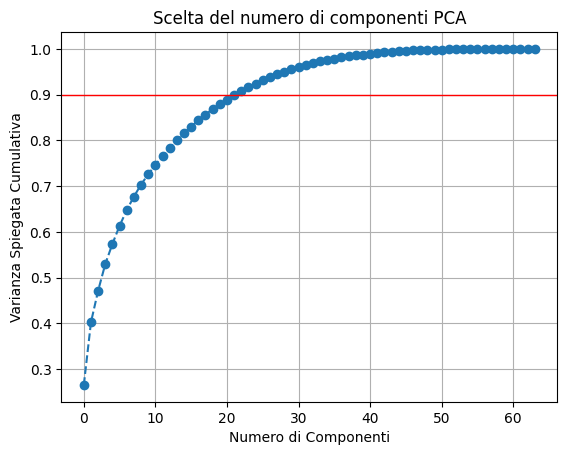

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df_imputed = df_pulito.copy()

# Riempi i NaN con il valore medio per 'Nome_Unità_Territoriale'
df_imputed[variabili_numeriche] = df_imputed.groupby('Nome_Unità_Territoriale')[variabili_numeriche].transform(
    lambda x: x.fillna(x.mean()))

colonne_da_escludere = ['Anno', 'Mese', 'Nome_Unità_Territoriale', 'Codice_Unità_Territoriale', 'Provincia']
colonne_pca = [col for col in variabili_numeriche if col not in colonne_da_escludere]
df_pca = df_imputed[colonne_pca]

# 2. Standardizza i dati
dati_standardizzati = StandardScaler().fit_transform(df_pca)

# 3. Esegui la PCA
pca = PCA()
pca_dati = pca.fit_transform(dati_standardizzati)

# 4. Calcola la varianza spiegata cumulativa
varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# 5. Determina il numero di componenti principali da tenere
num_componenti = np.argmax(varianza_cumulativa >= 0.90) + 1

# 6. Crea un DataFrame con le componenti principali
pca_df = pd.DataFrame(
    pca_dati[:, :num_componenti],
    columns=[f"PC{i+1}" for i in range(num_componenti)],
    index=df_pca.index
)

# 7. Aggiungi le componenti principali al DataFrame originale (opzionale)
df_risultati = pd.concat([df_imputed.loc[df_pca.index], pca_df], axis=1)

# 8. Stampa i risultati
print(df_risultati.head(2))

# 9. Grafico della varianza spiegata
plt.plot(varianza_cumulativa, marker='o', linestyle='--')
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del numero di componenti PCA")
plt.grid()
plt.axhline(0.9, color='red', linewidth=1)
plt.show()

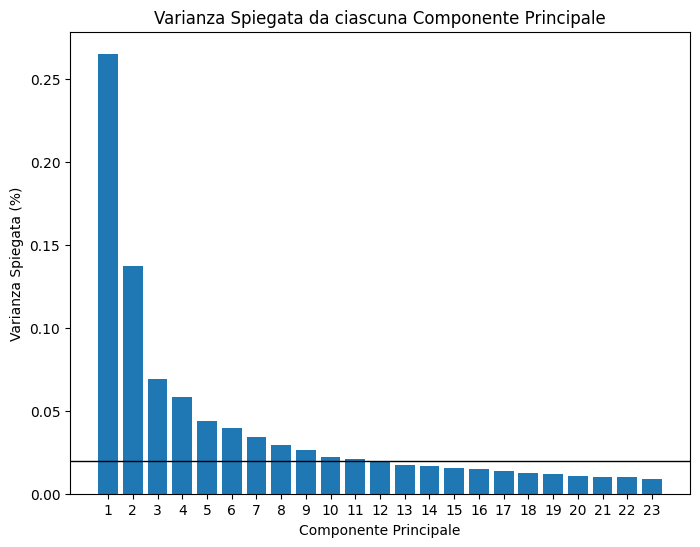

In [ ]:
# Grafico a barre per la varianza spiegata dalle componenti principali
plt.figure(figsize=(8, 6))
plt.bar(range(1, num_componenti+1), pca.explained_variance_ratio_[:num_componenti])
plt.xlabel("Componente Principale")
plt.ylabel("Varianza Spiegata (%)")
plt.title("Varianza Spiegata da ciascuna Componente Principale")
plt.xticks(range(1, num_componenti+1))  # Etichetta le componenti

plt.axhline(0.02, color='black', linewidth=1)

# Mostra il grafico
plt.show()


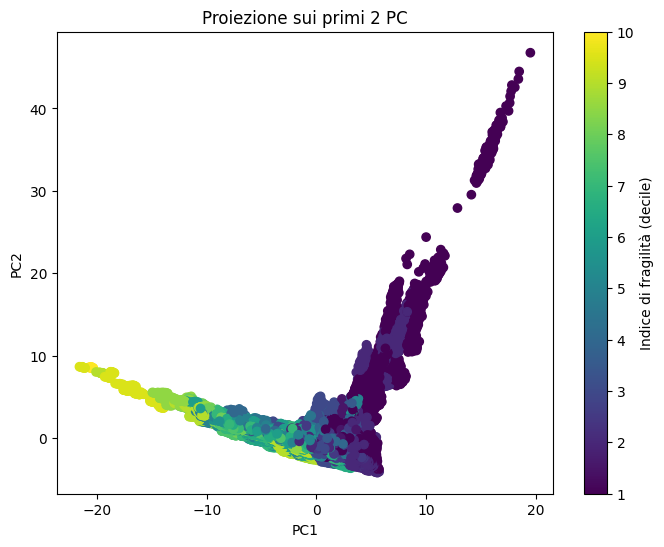

In [ ]:
# 11. Visualizza le prime 2 componenti principali
plt.figure(figsize=(8, 6))
plt.scatter(pca_dati[:, 0], pca_dati[:, 1], c=df_imputed['Indice di fragilità (decile)'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proiezione sui primi 2 PC')
plt.colorbar(label='Indice di fragilità (decile)')
plt.show()

Selezione delle variabili tramite carichi delle componenti principali

In [ ]:
# 1. Calcolare i carichi delle componenti principali
carichi_df = pd.DataFrame(pca.components_, columns=colonne_pca, index=[f"PC{i+1}" for i in range(pca.n_components_)])

# 2. Calcolare la somma dei carichi assoluti per ogni variabile su tutte le componenti principali
somma_carichi = carichi_df.abs().sum(axis=0)

# 3. Ordinare le variabili in base alla somma dei carichi (dal più alto al più basso)
variabili_ordinate = somma_carichi.sort_values(ascending=False)

# 4. Selezionare le prime 10 variabili più importanti
top_12_variabili = variabili_ordinate.head(12)

# 5. Mostrare le 12 variabili più importanti
print("Le 12 variabili più importanti in base ai carichi delle componenti principali:")
print(top_12_variabili)



Le 12 variabili più importanti in base ai carichi delle componenti principali:
% Pop 25-64 licenza di scuola media                                    5.933431
Temperatura minima media annuale                                       5.893182
Media abitazioni per edificio                                          5.796573
Densità abitativa                                                      5.779079
Tasso di occupazione _20-64 anni_                                      5.694410
Densità delle unità locali dell’industria e dei servizi - _ventile_    5.659618
Indice di accessibilità ai servizi essenziali                          5.620474
Tasso di mortalità 65+                                                 5.455376
% pop giovanile                                                        5.432757
% Area a Pericolosità da frana PAI media                               5.392962
Raccolta indifferenziata dei rifiuti urbani per abitante               5.382620
Consumo del suolo                        

Selezione delle variabili tramite Random Forest

In [ ]:
# Selezione delle variabili tramite Random Forest

from sklearn.ensemble import RandomForestClassifier

X = dati_standardizzati
y = df_imputed['Nome_Unità_Territoriale']

# Fitting del modello Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Importanza delle variabili
importances = rf.feature_importances_

# Crea un DataFrame per visualizzare le importanze
importances_df = pd.DataFrame(importances, index=colonne_pca, columns=['Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Mostra le prime 10 variabili
top_10_features = importances_df.head(10)
print(top_10_features)

                                                    Importance
% Aree a Pericolosità idraulica elevata               0.036290
% Edifici residenziali con stato di conservazio...    0.036219
Indice di vulnerabilità sociale e materiale           0.035805
% Edifici residenziali con stato di conservazio...    0.035664
Media abitazioni per edificio                         0.034807
% Edifici residenziali costruiti dopo il 2005         0.034644
Superficie territoriale (kmq)                         0.034380
% Edifici residenziali con stato di conservazio...    0.034324
% Edifici residenziali con stato di conservazio...    0.034229
% Edifici residenziali costruiti tra il 1981-2005     0.034008


## Cluster Analysis

### Metodo 1 (variabili principali)

Importazione librerie

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

Creazione struttura dati

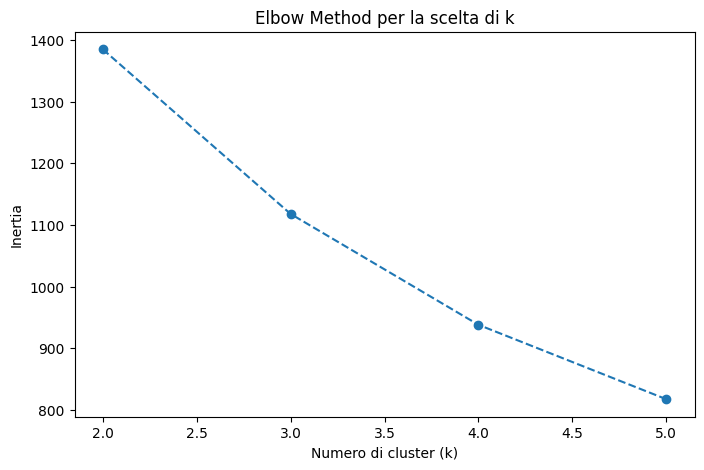

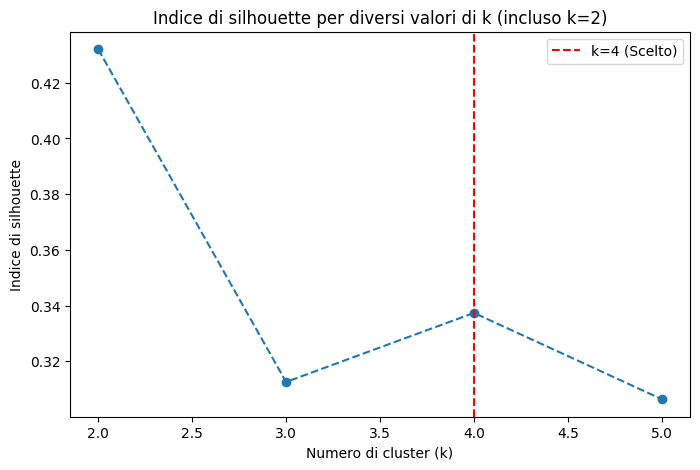

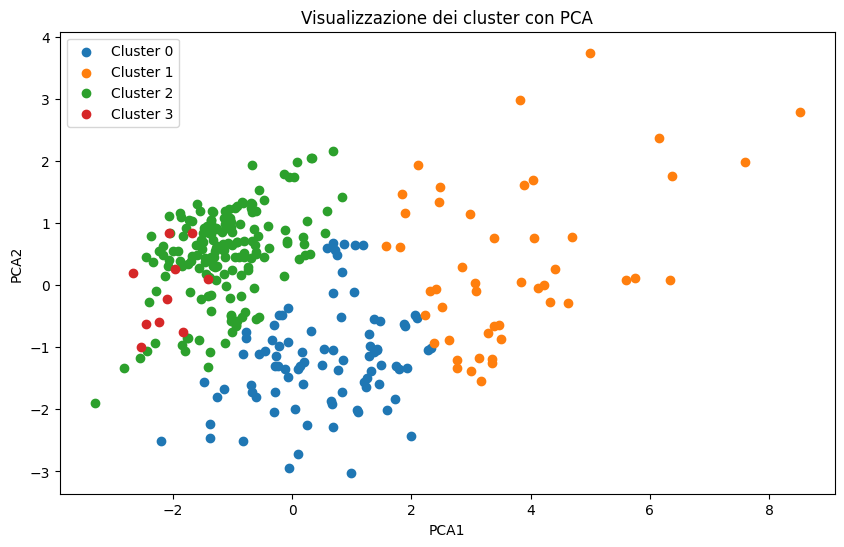

In [ ]:
# Aggregazione per unità territoriale (media nel tempo)
df_aggregated = df_pulito.groupby('Nome_Unità_Territoriale')[
    ['indice_eventi_estremi_annuali', 'Età media',
     'Tasso di incremento della popolazione', 'Altitudine (m)',
     '% grandi anziani', 'Densità abitativa',
     '% Area a Pericolosità da frana PAI molto elevata e elevata']
].mean().reset_index()

# Standardizzazione dei dati
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_aggregated.iloc[:, 1:])

# Elbow Method per determinare il numero ottimale di cluster (escludendo k=2)
inertia = []
max_k = 6
k_range = range(2, max_k)  # Inizia da k=2 per includerlo nel grafico

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Visualizzazione Elbow Method (a scopo informativo)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method per la scelta di k')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.show()

# Silhouette Score per determinare il numero ottimale di cluster
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualizzazione Silhouette Score, includendo k=2 ma evidenziando la scelta
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
best_k = max(range(3, max_k), key=lambda k: silhouette_scores[k-2])  # Selezione di k che massimizza l'indice di silhouette (escludendo k=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'k={best_k} (Scelto)')
plt.title('Indice di silhouette per diversi valori di k (incluso k=2)')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Indice di silhouette')
plt.legend()
plt.show()

# Applicare KMeans con il numero ottimale di cluster
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Usa il miglior k basato sull'indice di silhouette
df_aggregated['cluster'] = kmeans.fit_predict(df_scaled)

# Riduzione della dimensionalità con PCA per visualizzazione
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_aggregated['PCA1'] = pca_result[:, 0]
df_aggregated['PCA2'] = pca_result[:, 1]

# Scatter plot dei cluster
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    subset = df_aggregated[df_aggregated['cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')

plt.title('Visualizzazione dei cluster con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Esaminare la distribuzione delle unità territoriali nei cluster
df_aggregated[['Nome_Unità_Territoriale', 'cluster']].to_csv("clusters_output.csv", index=False)


Standardizzazione variabili

         indice_eventi_estremi_annuali  Età media  \
cluster                                             
0                             1.497727  45.882619   
1                             3.030208  52.255333   
2                             2.650286  44.223354   
3                             1.400000  44.501400   

         Tasso di incremento della popolazione  Altitudine (m)  \
cluster                                                          
0                                     0.001420      295.339773   
1                                    -0.010427      649.129167   
2                                     0.006331       52.720571   
3                                     0.005650       50.700000   

         % grandi anziani  Densità abitativa  \
cluster                                        
0               12.789943          88.026136   
1               20.680937          23.478125   
2               11.188371         264.742000   
3               11.499500        1593.400000

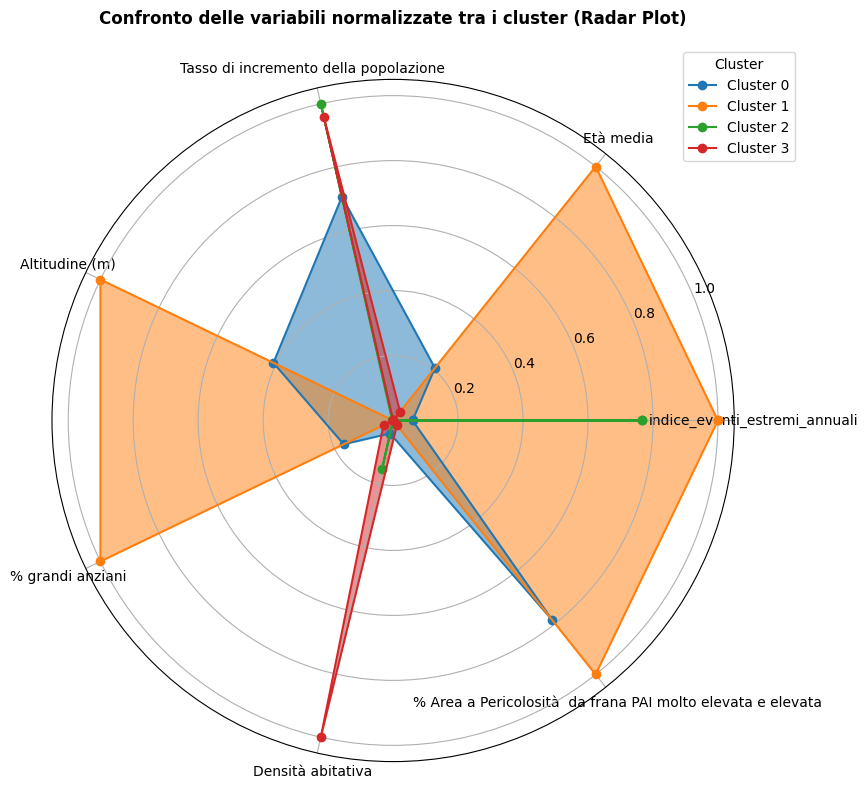

In [ ]:
# Calcolare le statistiche descrittive per ogni cluster
cluster_stats = df_aggregated.groupby('cluster')[['indice_eventi_estremi_annuali', 'Età media',
    'Tasso di incremento della popolazione', 'Altitudine (m)',
    '% grandi anziani', 'Densità abitativa', '% Area a Pericolosità da frana PAI molto elevata e elevata'
    ]].describe()

# Estrai le medie per ogni cluster per tutte le variabili
means = cluster_stats.xs('mean', axis=1, level=1)

# Mostrare la tabella con le medie per ogni cluster
print(means)

# Definire le categorie (nomi delle variabili)
categories = ['indice_eventi_estremi_annuali', 'Età media', 'Tasso di incremento della popolazione',
              'Altitudine (m)', '% grandi anziani', 'Densità abitativa', '% Area a Pericolosità  da frana PAI molto elevata e elevata']

# Calcolare gli angoli per il radar plot
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Aggiungere un punto extra a angles per chiudere il poligono
angles.append(angles[0])

# Creazione di un radar plot per ogni cluster
plt.figure(figsize=(10, 8))

# Inizializzare lo scaler Min-Max
scaler = MinMaxScaler()

# Normalizzare le medie per ogni cluster
means_normalized = scaler.fit_transform(means)

num_clusters = len(means)  # Determina il numero di cluster

for cluster in range(num_clusters):
    # Otteniamo i valori normalizzati per ogni variabile nel cluster
    cluster_data = means_normalized[cluster].tolist()

    # Aggiungiamo il primo valore alla fine per chiudere il poligono
    cluster_data.append(cluster_data[0])

    # Creiamo il radar plot (linee)
    plt.polar(angles, cluster_data, label=f'Cluster {cluster}', marker='o')

    # Riempire l'area con trasparenza (50%)
    plt.fill(angles, cluster_data, alpha=0.5)  # Riempimento con trasparenza al 50%

# Personalizzazione del grafico
plt.title('Confronto delle variabili normalizzate tra i cluster (Radar Plot)', fontweight='bold', pad=40)
plt.xticks(angles[:-1], categories, size=10)  # Utilizzare angles senza l'ultimo punto per le etichette

# Aggiustare la posizione della legenda
plt.legend(title='Cluster', bbox_to_anchor=(1.1, 1.05))  # Spostare la legenda a destra

# Aggiungere più spazio tra il grafico e i bordi
plt.subplots_adjust(right=0.8)

plt.tight_layout()
plt.show()


### Metodo 2 (solo variabili climatiche)

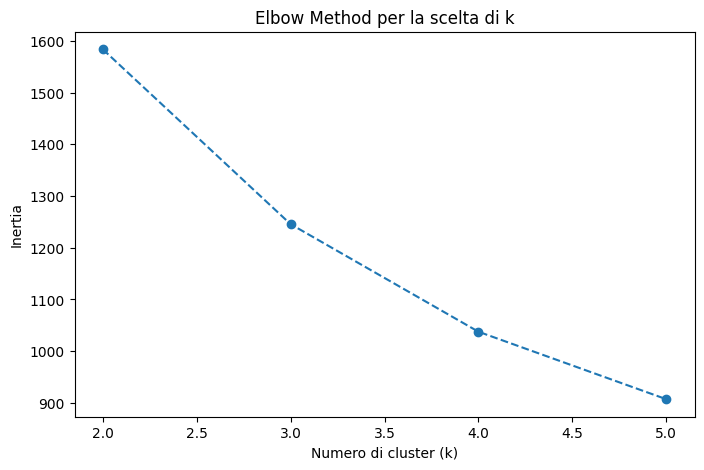

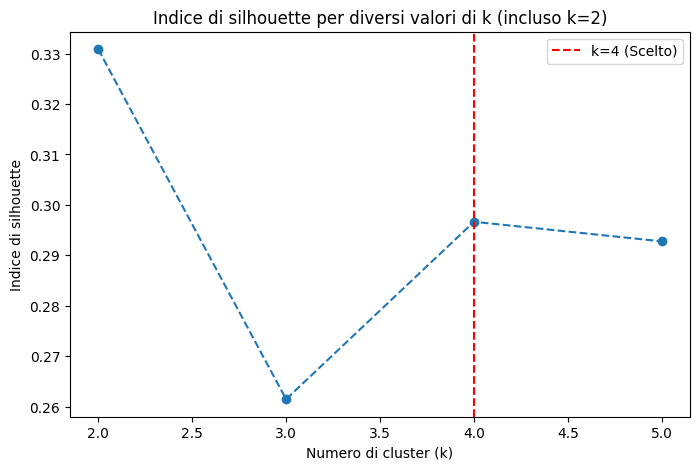

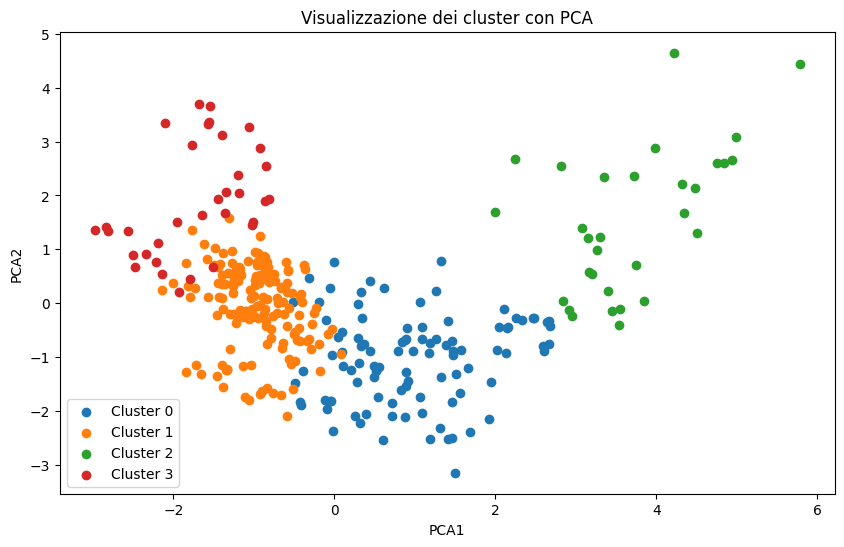

In [ ]:
# Aggregazione per unità territoriale (media nel tempo)
df_climatico = df_pulito.groupby('Nome_Unità_Territoriale')[
    ['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata']
].mean().reset_index()

# Standardizzazione dei dati
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_climatico.iloc[:, 1:])

# Elbow Method per determinare il numero ottimale di cluster (escludendo k=2)
inertia = []
max_k = 6
k_range = range(2, max_k)  # Inizia da k=2 per includerlo nel grafico

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Visualizzazione Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method per la scelta di k')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.show()

# Silhouette Score per determinare il numero ottimale di cluster
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualizzazione Silhouette Score, includendo k=2 ma evidenziando la scelta
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
best_k = max(range(3, max_k), key=lambda k: silhouette_scores[k-2])  # Selezione di k che massimizza l'indice di silhouette (escludendo k=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'k={best_k} (Scelto)')
plt.title('Indice di silhouette per diversi valori di k (incluso k=2)')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Indice di silhouette')
plt.legend()
plt.show()

# Applicare KMeans con il numero ottimale di cluster
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Usa il miglior k basato sull'indice di silhouette
df_climatico['cluster'] = kmeans.fit_predict(df_scaled)

# Riduzione della dimensionalità con PCA per visualizzazione
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_climatico['PCA1'] = pca_result[:, 0]
df_climatico['PCA2'] = pca_result[:, 1]

# Scatter plot dei cluster
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    subset = df_climatico[df_climatico['cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')

plt.title('Visualizzazione dei cluster con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Esaminare la distribuzione delle unità territoriali nei cluster
df_climatico[['Nome_Unità_Territoriale', 'cluster']].to_csv("clusters_output.csv", index=False)


In [ ]:
# Contare la numerosità per ciascun cluster
cluster_sizes = df_climatico.groupby('cluster').size()

# Visualizzare la numerosità per ogni cluster
print(cluster_sizes)

cluster
0     99
1    157
2     31
3     34
dtype: int64


         Precipitazioni medie annuali  Temperatura media annuale  \
cluster                                                            
0                           28.987520                  12.994662   
1                           23.221481                  13.993121   
2                           46.861339                  10.258306   
3                           23.958897                  13.769985   

         Variazione temperatura media annuale  \
cluster                                         
0                                    0.063773   
1                                    0.063841   
2                                    0.056290   
3                                    0.013015   

         Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale  \
cluster                                                                                                                              
0                           

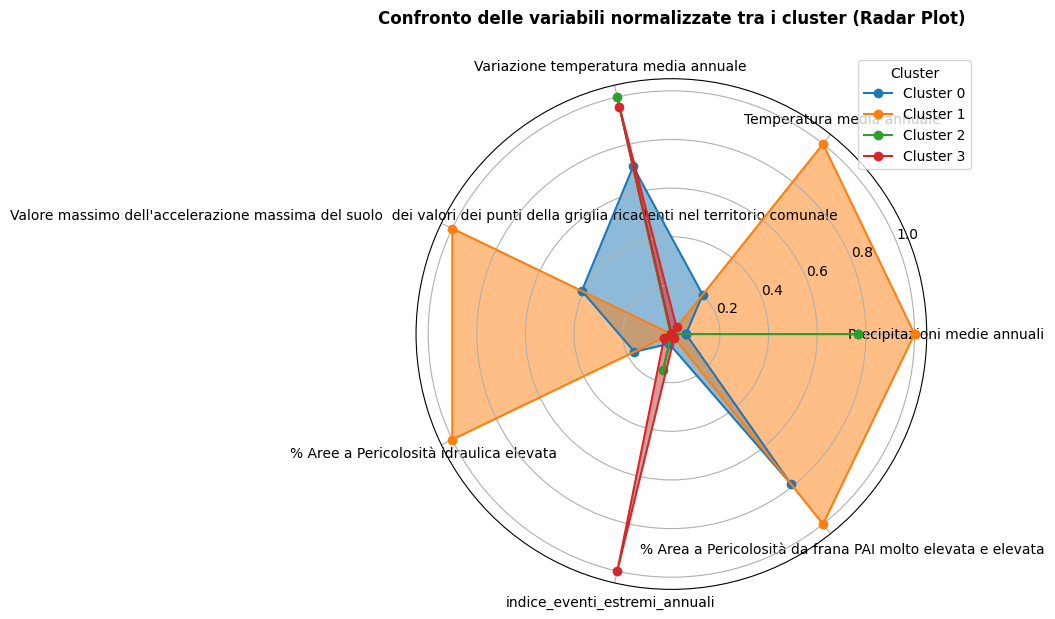

In [ ]:
# Calcolare le statistiche descrittive per ogni cluster
clusters_stats = df_climatico.groupby('cluster')[['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata'
    ]].mean()

print(clusters_stats)

# Definire le categorie (nomi delle variabili)
categories = ['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata']

# Calcolare gli angoli per il radar plot
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Aggiungere un punto extra a angles per chiudere il poligono
angles.append(angles[0])

# Creazione di un radar plot per ogni cluster
plt.figure(figsize=(10, 8))

# Inizializzare lo scaler Min-Max
scaler = MinMaxScaler()

# Normalizzare le medie per ogni cluster
means_normalized = scaler.fit_transform(means)

num_clusters = len(means)  # Determina il numero di cluster

for cluster in range(num_clusters):
    # Otteniamo i valori normalizzati per ogni variabile nel cluster
    cluster_data = means_normalized[cluster].tolist()

    # Aggiungiamo il primo valore alla fine per chiudere il poligono
    cluster_data.append(cluster_data[0])

    # Creiamo il radar plot (linee)
    plt.polar(angles, cluster_data, label=f'Cluster {cluster}', marker='o')

    # Riempire l'area con trasparenza (50%)
    plt.fill(angles, cluster_data, alpha=0.5)  # Riempimento con trasparenza al 50%

# Personalizzazione del grafico
plt.title('Confronto delle variabili normalizzate tra i cluster (Radar Plot)', fontweight='bold', pad=40)
plt.xticks(angles[:-1], categories, size=10)  # Utilizzare angles senza l'ultimo punto per le etichette

# Aggiustare la posizione della legenda
plt.legend(title='Cluster', bbox_to_anchor=(1.1, 1.05))  # Spostare la legenda a destra

# Aggiungere più spazio tra il grafico e i bordi
plt.subplots_adjust(right=0.8)

plt.tight_layout()
plt.show()


In [ ]:
# Esegui un merge tra df_completo e df_climatico (che contiene i cluster) sulla colonna 'Città'
df_pulito = df_pulito.merge(df_climatico[['Nome_Unità_Territoriale', 'cluster']], on='Nome_Unità_Territoriale', how='left')

In [ ]:
# Calcolare le statistiche descrittive per ogni cluster
demographic_stats = df_pulito.groupby('cluster')[['Tasso di mortalità 65+',
       'Tasso di mortalità 85+',
       'Tasso di incremento della popolazione', 'Tasso di natalità',
       'Tasso di mortalità'
    ]].mean()

print(demographic_stats)


         Tasso di mortalità 65+  Tasso di mortalità 85+  \
cluster                                                   
0                   3851.617222             3402.831944   
1                   3527.081360             2876.749701   
2                   4200.123516             3799.456484   
3                   3727.614809             3034.699250   

         Tasso di incremento della popolazione  Tasso di natalità  \
cluster                                                             
0                                     0.000217         595.469692   
1                                     0.006045         695.635688   
2                                    -0.009016         430.357113   
3                                     0.002882         634.692015   

         Tasso di mortalità  
cluster                      
0               1821.458202  
1               1387.244529  
2               2485.566468  
3               1561.349029  


Test ANOVA per capire quali variabili climatiche e demografiche sono più diverse

In [ ]:
from scipy.stats import f_oneway

# Variabili climatiche e demografiche
climate_variables = ['Precipitazioni medie annuali', 'Temperatura media annuale', 'Variazione temperatura media annuale',
             "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
             '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
             '% Area a Pericolosità da frana PAI molto elevata e elevata']

demographic_variables = ['Tasso di mortalità 65+',
       'Tasso di mortalità 85+',
       'Tasso di incremento della popolazione', 'Tasso di natalità',
       'Tasso di mortalità']

# Funzione per eseguire l'ANOVA e stampare i risultati
def run_anova(variable_list, category_name):
    print(f"\n{'-'*40}\nTest ANOVA per le variabili {category_name}:\n{'-'*40}")
    for variable in variable_list:
        # Dividi i dati in gruppi per ogni cluster
        groups = [df_pulito[df_pulito['cluster'] == cluster][variable] for cluster in df_pulito['cluster'].unique()]

        # Esegui il test ANOVA
        f_statistic, p_value = f_oneway(*groups)

        # Risultati
        print(f"\nTest ANOVA per {variable}:")
        print(f"F-statistic: {f_statistic}")
        print(f"P-value: {p_value}")

        # Interpretazione
        if p_value < 0.05:
            print(f" Le medie per \033[1m{variable}\033[0m sono significativamente diverse tra i cluster.")
        else:
            print(f"Le medie per {variable} NON sono significativamente diverse tra i cluster.")

# Esegui l'ANOVA per le variabili climatiche
run_anova(climate_variables, "Climatiche")

# Esegui l'ANOVA per le variabili demografiche
run_anova(demographic_variables, "Demografiche")



----------------------------------------
Test ANOVA per le variabili Climatiche:
----------------------------------------

Test ANOVA per Precipitazioni medie annuali:
F-statistic: 22691.54346566432
P-value: 0.0
 Le medie per Precipitazioni medie annuali sono significativamente diverse tra i cluster.

Test ANOVA per Temperatura media annuale:
F-statistic: 34419.76031347394
P-value: 0.0
 Le medie per Temperatura media annuale sono significativamente diverse tra i cluster.

Test ANOVA per Variazione temperatura media annuale:
F-statistic: 15.043142350547155
P-value: 8.739924282062711e-10
 Le medie per Variazione temperatura media annuale sono significativamente diverse tra i cluster.

Test ANOVA per Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale:
F-statistic: nan
P-value: nan
Le medie per Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale NON 

In [ ]:
# Calcolare le statistiche descrittive per ogni cluster
social_stats = df_pulito.groupby('cluster')[['Altitudine (m)','Consumo del suolo',
       'Densità delle unità locali dell’industria e dei servizi - _ventile_',
       'Età media', 'Grado di urbanizzazione',
       'Indice di fragilità (decile)',
       'Indice di accessibilità ai servizi essenziali',
       'Indice di esposizione demografica',
       'Indice di vulnerabilità sociale e materiale',
       '% grandi anziani', '% pop anziana', '% pop giovanile',
       '% pop in età lavorativa', 'pop totale',
       '% Edifici residenziali costruiti dopo il 2005',
       'Superficie territoriale (kmq)',
       'Tasso di motorizzazione ad alta emissione',
       'Tasso di occupazione _20-64 anni_',
       '% Pop 25-64 licenza di scuola media',
       '% Edifici residenziali con stato di conservazione buono',
       '% Edifici residenziali con stato di conservazione medio',
       '% Edifici residenziali con stato di conservazione ottimo',
       '% Edifici residenziali con stato di conservazione pessimo',
       'Media abitazioni per edificio', 'Media residenti per abitazione',
       '% Edifici residenziali costruiti prima del 1981',
       '% Edifici residenziali costruiti tra il 1981-2005',
       'Densità abitativa', 'Indice di vecchiaia',
    ]].mean()

print(social_stats)


         Altitudine (m)  Consumo del suolo  \
cluster                                      
0            365.705051           5.750253   
1             51.976115          14.491752   
2            679.096774           3.411935   
3             43.063235           9.897353   

         Densità delle unità locali dell’industria e dei servizi - _ventile_  \
cluster                                                                        
0                                                13.060606                     
1                                                14.347134                     
2                                                16.290323                     
3                                                13.191176                     

         Età media  Grado di urbanizzazione  Indice di fragilità (decile)  \
cluster                                                                     
0        46.851874                 1.151515                      5.040404   
1        44

## 2. Qual è la relazione tra l'età media della popolazione con lo stato degli edifici (data di costruzione e stato di conservazione), e la fragilità naturale (precipitazioni, frane, rischi idraulici)?

In [ ]:
# importo le library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [ ]:
# filtro il dataset per il 2018
df_2018 = df_pulito[df_pulito['Anno'] == 2018]

Correlazione di Pearson: 0.14 (p-value: 0.0000)
Correlazione di Spearman: 0.03 (p-value: 0.0432)


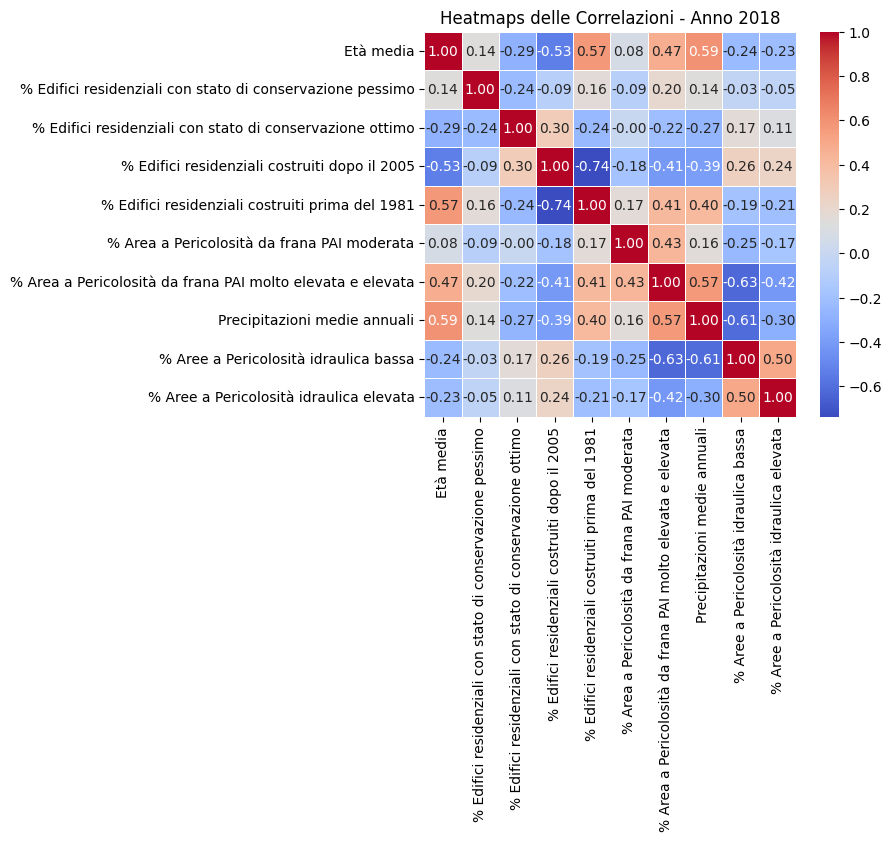

In [ ]:
# Calcolo delle correlazioni
corr_pearson, p_pearson = pearsonr(df_2018['Età media'], df_2018['% Edifici residenziali con stato di conservazione pessimo'])
corr_spearman, p_spearman = spearmanr(df_2018['Età media'], df_2018['% Edifici residenziali con stato di conservazione pessimo'])

print(f"Correlazione di Pearson: {corr_pearson:.2f} (p-value: {p_pearson:.4f})")
print(f"Correlazione di Spearman: {corr_spearman:.2f} (p-value: {p_spearman:.4f})")

# Seleziona solo le colonne numeriche per calcolare la correlazione
df_2018 = df_2018[['Età media', '% Edifici residenziali con stato di conservazione pessimo','% Edifici residenziali con stato di conservazione ottimo','% Edifici residenziali costruiti dopo il 2005','% Edifici residenziali costruiti prima del 1981','% Area a Pericolosità da frana PAI moderata','% Area a Pericolosità da frana PAI molto elevata e elevata','Precipitazioni medie annuali',
                               '% Aree a Pericolosità idraulica bassa','% Aree a Pericolosità idraulica elevata']]

# Calcola la matrice di correlazione
corr_matrix = df_2018.corr()

# Visualizza la matrice di correlazione
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmaps delle Correlazioni - Anno 2018")
plt.show()

Modello lineare multiplo per Età Media

In [ ]:
import statsmodels.api as sm

In [ ]:
# Seleziona le variabili indipendenti (più colonne) e la variabile dipendente

X = df_2018[['% Edifici residenziali con stato di conservazione pessimo','% Edifici residenziali costruiti prima del 1981',
             '% Area a Pericolosità da frana PAI molto elevata e elevata','% Aree a Pericolosità idraulica elevata',
             '% Aree a Pericolosità idraulica bassa','% Edifici residenziali con stato di conservazione ottimo']]
y = df_2018['Età media']

# Aggiungi l'intercetta a X
X = sm.add_constant(X)

# Crea il modello di regressione
model = sm.OLS(y, X).fit()

# Visualizza i risultati del modello
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Età media   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     452.0
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:33:43   Log-Likelihood:                -9382.4
No. Observations:                3852   AIC:                         1.878e+04
Df Residuals:                    3845   BIC:                         1.882e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

## Quali sono le caratteristiche più influenti per le Morti 65+?

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

90esimo percentile

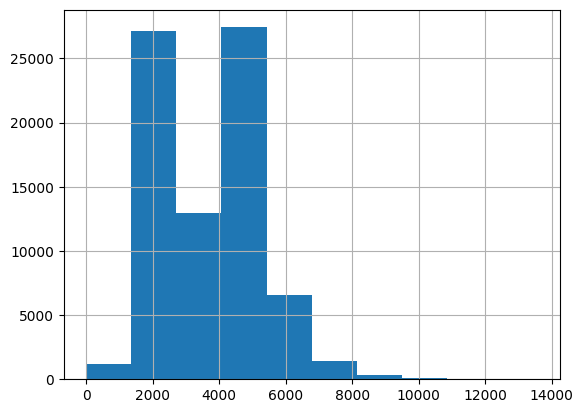

Optimization terminated successfully.
         Current function value: 0.289170
         Iterations 7
                                 Logit Regression Results                                 
Dep. Variable:     Tasso di mortalità 65+_binario   No. Observations:                77040
Model:                                      Logit   Df Residuals:                    77030
Method:                                       MLE   Df Model:                            9
Date:                            Mon, 24 Feb 2025   Pseudo R-squ.:                  0.1105
Time:                                    14:33:44   Log-Likelihood:                -22278.
converged:                                   True   LL-Null:                       -25044.
Covariance Type:                        nonrobust   LLR p-value:                     0.000
                                                                                                                                coef    std err          z      P>|z|     

In [ ]:
# Selezione delle variabili indipendenti (modifica secondo le tue esigenze)
variabili_indipendenti = ['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura massima media annuale',
     'Temperatura minima media annuale']

df_annuale['Tasso di mortalità 65+'].hist()
plt.show()

# Calcolo del 90° percentile
percentile_90 = np.percentile(df_annuale['Tasso di mortalità 65+'], 90)

# Creazione della variabile binaria
df_annuale['Tasso di mortalità 65+_binario'] = (df_annuale['Tasso di mortalità 65+'] >= percentile_90).astype(int)

# Creazione della matrice X con costante
X = sm.add_constant(df_annuale[variabili_indipendenti])

# Variabile dipendente
y = df_annuale['Tasso di mortalità 65+_binario']

# Stima del modello Logit
modello_logit = sm.Logit(y, X)
risultati = modello_logit.fit()

# Stampa dei risultati
print(risultati.summary())

# Calcolo del VIF per ogni variabile
vif = pd.DataFrame()
vif['Variabile'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Visualizza i risultati
print(vif)

Optimization terminated successfully.
         Current function value: 0.293288
         Iterations 7
                                 Logit Regression Results                                 
Dep. Variable:     Tasso di mortalità 65+_binario   No. Observations:                77040
Model:                                      Logit   Df Residuals:                    77034
Method:                                       MLE   Df Model:                            5
Date:                            Mon, 24 Feb 2025   Pseudo R-squ.:                 0.09781
Time:                                    14:33:45   Log-Likelihood:                -22595.
converged:                                   True   LL-Null:                       -25044.
Covariance Type:                        nonrobust   LLR p-value:                     0.000
                                                                                                                                coef    std err          z      P>|z|     

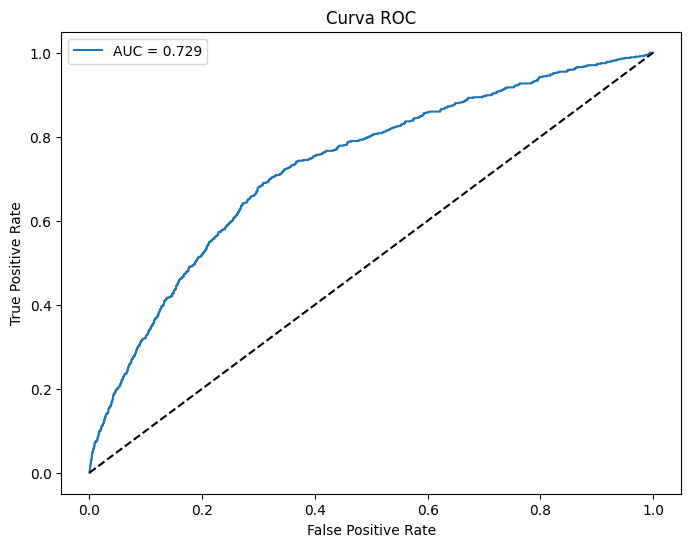

In [ ]:
# Selezione delle variabili indipendenti
variabili_indipendenti_ridotte = ['Precipitazioni medie annuali','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura minima media annuale']

# Creazione della matrice X con costante
X_ridotto = sm.add_constant(df_imputed[variabili_indipendenti_ridotte])

# Stima del modello Logit
modello_logit = sm.Logit(y, X_ridotto)
risultati_nuovi = modello_logit.fit()

# Stampa dei risultati
print(risultati_nuovi.summary())

# Calcolo del VIF per ogni variabile
vif = pd.DataFrame()
vif['Variabile'] = X_ridotto.columns
vif['VIF'] = [variance_inflation_factor(X_ridotto.values, i) for i in range(X_ridotto.shape[1])]

# Visualizza i risultati
print(vif)

# Calcolare gli odds ratio (OR) esponenziando i coefficienti
odds_ratios = np.exp(risultati_nuovi.params)

# Visualizzare gli odds ratio
print(odds_ratios)

# Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni delle probabilità
y_pred_proba = risultati_nuovi.predict(X_ridotto)

# Calcolo ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

# Plot della curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')  # Linea diagonale casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

10ecimo percentile

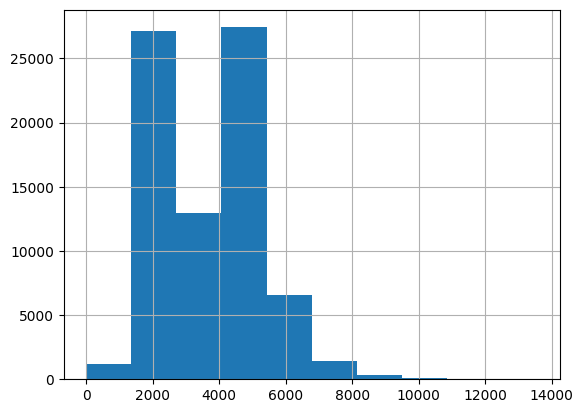

Optimization terminated successfully.
         Current function value: 0.301192
         Iterations 7
                                   Logit Regression Results                                  
Dep. Variable:     Tasso di mortalità 65+_binario_10   No. Observations:                77040
Model:                                         Logit   Df Residuals:                    77030
Method:                                          MLE   Df Model:                            9
Date:                               Mon, 24 Feb 2025   Pseudo R-squ.:                 0.07349
Time:                                       14:33:46   Log-Likelihood:                -23204.
converged:                                      True   LL-Null:                       -25044.
Covariance Type:                           nonrobust   LLR p-value:                     0.000
                                                                                                                                coef    std err   

In [ ]:
# Selezione delle variabili indipendenti (modifica secondo le tue esigenze)
variabili_indipendenti = ['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura massima media annuale',
     'Temperatura minima media annuale']

df_annuale['Tasso di mortalità 65+'].hist()
plt.show()

# Calcolo del 10° percentile
percentile_10= np.percentile(df_annuale['Tasso di mortalità 65+'], 10)

# Creazione della variabile binaria
df_annuale['Tasso di mortalità 65+_binario_10'] = (df_annuale['Tasso di mortalità 65+'] <= percentile_10).astype(int)

# Creazione della matrice X con costante
X = sm.add_constant(df_annuale[variabili_indipendenti])

# Variabile dipendente
y = df_annuale['Tasso di mortalità 65+_binario_10']

# Stima del modello Logit
modello_logit = sm.Logit(y, X)
risultati = modello_logit.fit()

# Stampa dei risultati
print(risultati.summary())

# Calcolo del VIF per ogni variabile
vif = pd.DataFrame()
vif['Variabile'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Visualizza i risultati
print(vif)

Optimization terminated successfully.
         Current function value: 0.301473
         Iterations 7
                                   Logit Regression Results                                  
Dep. Variable:     Tasso di mortalità 65+_binario_10   No. Observations:                77040
Model:                                         Logit   Df Residuals:                    77034
Method:                                          MLE   Df Model:                            5
Date:                               Mon, 24 Feb 2025   Pseudo R-squ.:                 0.07263
Time:                                       14:33:47   Log-Likelihood:                -23226.
converged:                                      True   LL-Null:                       -25044.
Covariance Type:                           nonrobust   LLR p-value:                     0.000
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

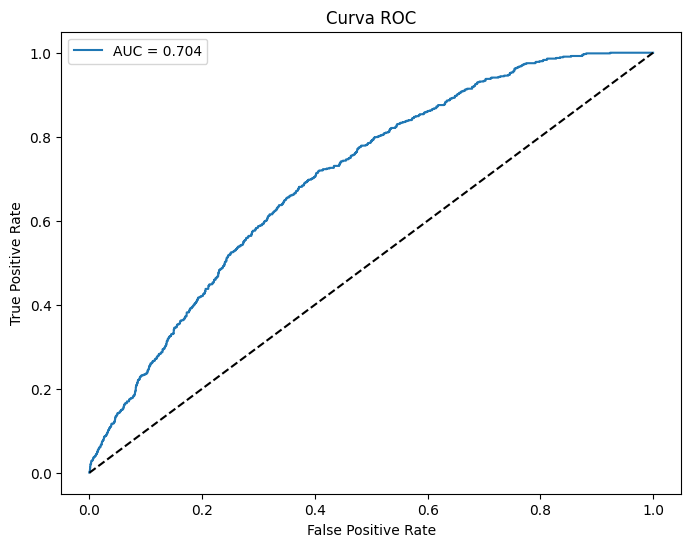

In [ ]:
# Selezione delle variabili indipendenti (modifica secondo le tue esigenze)
variabili_indipendenti_ridotte = ['Precipitazioni medie annuali','Variazione temperatura media annuale',
    'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura massima media annuale']

# Creazione della matrice X con costante
X_ridotto = sm.add_constant(df_annuale[variabili_indipendenti_ridotte])

# Stima del modello Logit
modello_logit = sm.Logit(y, X_ridotto)
risultati_nuovi = modello_logit.fit()

# Stampa dei risultati
print(risultati_nuovi.summary())

# Calcolo del VIF per ogni variabile
vif = pd.DataFrame()
vif['Variabile'] = X_ridotto.columns
vif['VIF'] = [variance_inflation_factor(X_ridotto.values, i) for i in range(X_ridotto.shape[1])]

# Visualizza i risultati
print(vif)

# Calcolare gli odds ratio (OR) esponenziando i coefficienti
odds_ratios = np.exp(risultati_nuovi.params)

# Visualizzare gli odds ratio
print(odds_ratios)

# Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni delle probabilità
y_pred_proba = risultati_nuovi.predict(X_ridotto)

# Calcolo ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

# Plot della curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')  # Linea diagonale casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Quali sono le caratteristiche distintive delle aree interessate dal fenomeno del depopolamento?

In [ ]:
# Rimuovi la colonna 'Anno' da df_annuale
df_comuni = df_annuale.drop('Anno', axis=1)

# Raggruppa per 'Nome Unità Territoriale' e calcola la media per le variabili numeriche
df_comuni = df_comuni.groupby('Nome_Unità_Territoriale')[variabili_numeriche].mean().reset_index()

# Unisci il dataframe df_comuni con df_pop (popolazione, spopolamento, migrazione) sul campo 'Nome_Unità_Territoriale'
df_comuni = df_comuni.merge(df_pop[['Nome_Unità_Territoriale', 'Spopolamento', 'Migrazione']],
                             on=['Nome_Unità_Territoriale'],
                             how='left')

In [ ]:
X = df_comuni[['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura massima media annuale',
     'Temperatura minima media annuale']]
y = df_comuni['Spopolamento']

# Aggiungi l'intercetta a X
X = sm.add_constant(X)

# Crea il modello di regressione
model = sm.OLS(y, X).fit()

# Visualizza i risultati del modello
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Spopolamento   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     33.16
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           1.31e-40
Time:                        14:33:47   Log-Likelihood:                -1233.1
No. Observations:                 321   AIC:                             2486.
Df Residuals:                     311   BIC:                             2524.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
X = df_comuni[['Precipitazioni medie annuali', 'Temperatura media annuale','Variazione temperatura media annuale',
     "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale",
     '% Aree a Pericolosità idraulica elevata', 'indice_eventi_estremi_annuali',
     '% Area a Pericolosità da frana PAI molto elevata e elevata','Temperatura massima media annuale',
     'Temperatura minima media annuale']]
y = df_comuni['Migrazione']

# Aggiungi l'intercetta a X
X = sm.add_constant(X)

# Crea il modello di regressione
model = sm.OLS(y, X).fit()

# Visualizza i risultati del modello
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Migrazione   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.239
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           1.20e-06
Time:                        14:33:47   Log-Likelihood:                -1148.9
No. Observations:                 321   AIC:                             2318.
Df Residuals:                     311   BIC:                             2356.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------